# Scrap and Sentiment Analysis of Halodoc Reviews App

### Naura Jasmine Azzahra
### 5026211005

# Import Library

In [1]:
  !pip install google_play_scraper
!pip install textblob
from google_play_scraper import app, Sort, reviews_all
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

C:\Users\User\AppData\Local\Temp\ipykernel_37236\3706398329.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


#Data Preprocessing

In [2]:
#Android App Halodoc link from Google Play at
#https://play.google.com/store/apps/details?id=com.linkdokter.halodoc.android
#The apps ID found in the link after id=com.linkdokter.halodoc.android
#The apps name on Google Play titled: Halodoc : Dokter, Obat, & Lab
#Dated 29 August 2024: number of reviews 450k++

from google_play_scraper import app, Sort, reviews_all

halodoc_reviews = reviews_all(
    'com.linkdokter.halodoc.android',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [7]:
#Save the Halodoc Apps reviews into dataframe
df_hdrev = pd.DataFrame(np.array(halodoc_reviews),columns=['content'])
df_hdrev = df_hdrev.join(pd.DataFrame(df_hdrev.pop('content').tolist()))
df_hdrev.to_csv(r'df_halodoc.csv', index=False)
df_hdrev.head()

reviewId       userName  \
0  201d876c-ae7d-45b2-859d-b74e485c1a91  A Google user   
1  ecd43d0d-7686-447d-8da3-b7567f049a8f  A Google user   
2  482274f3-08bb-46ee-a911-a613476563b9  A Google user   
3  cbe22d87-5de9-4938-9291-3ba4f30e21de  A Google user   
4  b1b79138-c93c-49a6-8aa0-5f27e97b2fff  A Google user   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                          content  score  thumbsUpCount reviewCreatedVersion  \
0       Dokternya baik dan ramah.      5              0               22.600   
1                   Cukup membatu      5              0               22.600   
2  Sangat penting dan di butuhkan      5              0               22.600   
3                            Good      5              0               22.600   
4                            Good      4              0               22.600   

                   at                                       replyContent  \
0 2024-09-09 12:38:35  Hai Esther Meiliani! Terima kasih sudah menggu...   
1 2024-09-09 03:53:10  Hai Хенди! Terima kasih sudah menggunakan Halo...   
2 2024-09-08 21:03:01  Hai Caleb Nikao Hutabarat! Terima kasih sudah ...   
3 2024-09-08 17:31:24  Hai kiyo nala! Terima kasih sudah menggunakan ...   
4 2024-09-08 16:03:02  Hai RimaR Septaviani! Terima kasih sudah mengg...   

            repliedAt appVersion  
0 2024-09-09 13:23:24     22.600  
1 2024-09-09 04:28:41     22.600  
2 2024-09-09 01:32:51     22.600  
3 2024-09-08 19:33:57     22.600  
4 2024-09-08 16:11:54     22.600

In [8]:
#Information on the table
df_hdrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35931 entries, 0 to 35930
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              35931 non-null  object        
 1   userName              35931 non-null  object        
 2   userImage             35931 non-null  object        
 3   content               35931 non-null  object        
 4   score                 35931 non-null  int64         
 5   thumbsUpCount         35931 non-null  int64         
 6   reviewCreatedVersion  32694 non-null  object        
 7   at                    35931 non-null  datetime64[ns]
 8   replyContent          35928 non-null  object        
 9   repliedAt             35928 non-null  datetime64[ns]
 10  appVersion            32694 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 3.0+ MB


In [9]:
df_hdrev.loc[:,["content","score"]]

content  score
0                              Dokternya baik dan ramah.      5
1                                          Cukup membatu      5
2                         Sangat penting dan di butuhkan      5
3                                                   Good      5
4                                                   Good      4
...                                                  ...    ...
35926                         It's very easy and helpful      5
35927  Sepertinya ini aplikasi pertama di Indonesia.....      5
35928                                    Good aplication      5
35929                           This is simplying health      5
35930  Aplikasi inovatif... Bisa mendatangkan RS ke r...      5

[35931 rows x 2 columns]

In [6]:
# return unique valuefrom df
print(df_hdrev.reviewCreatedVersion.unique())
print(df_hdrev.reviewCreatedVersion.nunique())

['22.600' None '22.502' '16.813' '22.100' '21.900' '22.400' '18.900'
 '22.200' '22.301' '22.000' '21.700' '21.800' '20.300' '21.400' '21.510'
 '21.500' '21.210' '21.301' '21.600' '21.200' '14.401' '20.601' '15.100'
 '6.501' '20.501' '20.900' '21.100' '20.801' '20.700' '21.001' '20.100'
 '13.900' '16.602' '20.800' '20.510' '20.202' '17.303' '20.400' '20.001'
 '19.900' '19.600' '19.501' '13.301' '20.201' '11.510' '19.801' '19.402'
 '19.701' '18.002' '18.610' '19.300' '19.700' '11.902' '18.800' '19.000'
 '19.101' '17.000' '19.200' '18.300' '17.202' '16.510' '19.210' '16.100'
 '19.100' '15.000' '18.701' '18.600' '18.101' '18.510' '17.502' '18.700'
 '18.501' '17.703' '18.201' '10.701' '17.100' '17.902' '17.901' '17.602'
 '9.900' '17.802' '16.900' '17.302' '17.701' '17.601' '17.101' '17.501'
 '6.200' '14.900' '16.812' '16.111' '16.401' '16.411' '16.811' '16.701'
 '16.601' '7.010' '16.501' '11.500' '12.800' '16.112' '11.600' '16.301'
 '16.202' '16.110' '15.801' '16.201' '9.301' '16.001' '15.7

In [11]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_hdrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

content  score  \
0                              Dokternya baik dan ramah.      5   
1                                          Cukup membatu      5   
2                         Sangat penting dan di butuhkan      5   
3                                                   Good      5   
4                                                   Good      4   
...                                                  ...    ...   
35926                         It's very easy and helpful      5   
35927  Sepertinya ini aplikasi pertama di Indonesia.....      5   
35928                                    Good aplication      5   
35929                           This is simplying health      5   
35930  Aplikasi inovatif... Bisa mendatangkan RS ke r...      5   

       thumbsUpCount      reviewCreatedVersion                  at  \
0                  0                    22.600 2024-09-09 12:38:35   
1                  0                    22.600 2024-09-09 03:53:10   
2                  0                    22.600 2024-09-08 21:03:01   
3                  0                    22.600 2024-09-08 17:31:24   
4                  0                    22.600 2024-09-08 16:03:02   
...              ...                       ...                 ...   
35926              2                      None 2016-04-02 12:54:34   
35927              4  0.16.2-build201603301019 2016-04-02 11:06:15   
35928              1  0.16.2-build201603301019 2016-04-02 11:02:41   
35929              1  0.13.1-build201603171038 2016-03-18 19:11:25   
35930              2  0.13.1-build201603171038 2016-03-18 10:55:43   

                                            replyContent           repliedAt  
0      Hai Esther Meiliani! Terima kasih sudah menggu... 2024-09-09 13:23:24  
1      Hai Хенди! Terima kasih sudah menggunakan Halo... 2024-09-09 04:28:41  
2      Hai Caleb Nikao Hutabarat! Terima kasih sudah ... 2024-09-09 01:32:51  
3      Hai kiyo nala! Terima kasih sudah menggunakan ... 2024-09-08 19:33:57  
4      Hai RimaR Septaviani! Terima kasih sudah mengg... 2024-09-08 16:11:54  
...                                                  ...                 ...  
35926  Hai! Terima kasih sudah menggunakan Halodoc. J... 2019-12-16 08:16:39  
35927  Hai! Terima kasih sudah menggunakan Halodoc. J... 2019-12-16 08:19:05  
35928  Hai! Terima kasih sudah menggunakan Halodoc. J... 2019-12-16 08:19:03  
35929  Hai! Terima kasih sudah menggunakan Halodoc. J... 2019-12-16 08:17:08  
35930  Hai! Terima kasih sudah menggunakan Halodoc. J... 2019-12-16 08:17:06  

[35931 rows x 7 columns]

In [12]:
!pip install emoji
!pip install wordcloud

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

## Step 1 - Sentiment Polarity and Subjective Before Preprocessing

In [13]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_hdrev['sentiment_polarity'] = df_hdrev['content'].apply(lambda x: TextBlob(x).polarity)
df_hdrev['sentiment_subjective'] = df_hdrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [14]:
#df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

content  \
0                                                                                                                                        Dokternya baik dan ramah.   
1                                                                                                                                                    Cukup membatu   
2                                                                                                                                   Sangat penting dan di butuhkan   
3                                                                                                                                                             Good   
4                                                                                                                                                             Good   
...                                                                                                                                                            ...   
35926                                                                                                                                   It's very easy and helpful   
35927  Sepertinya ini aplikasi pertama di Indonesia.. Yg menghubungkan online dg dokter.. Memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              Good aplication   
35929                                                                                                                                     This is simplying health   
35930                                                                                                   Aplikasi inovatif... Bisa mendatangkan RS ke rumah sendiri   

       score  sentiment_polarity  sentiment_subjective  
0          5            0.000000                   0.0  
1          5            0.000000                   0.0  
2          5            0.000000                   0.0  
3          5            0.700000                   0.6  
4          4            0.700000                   0.6  
...      ...                 ...                   ...  
35926      5            0.563333                   1.0  
35927      5            0.000000                   0.0  
35928      5            0.700000                   0.6  
35929      5            0.000000                   0.0  
35930      5            0.000000                   0.0  

[35931 rows x 4 columns]

In [15]:
#Check number of reviews scores
df_hdrev['score'].value_counts()

score
5    29710
1     2664
4     2201
3      755
2      601
Name: count, dtype: int64

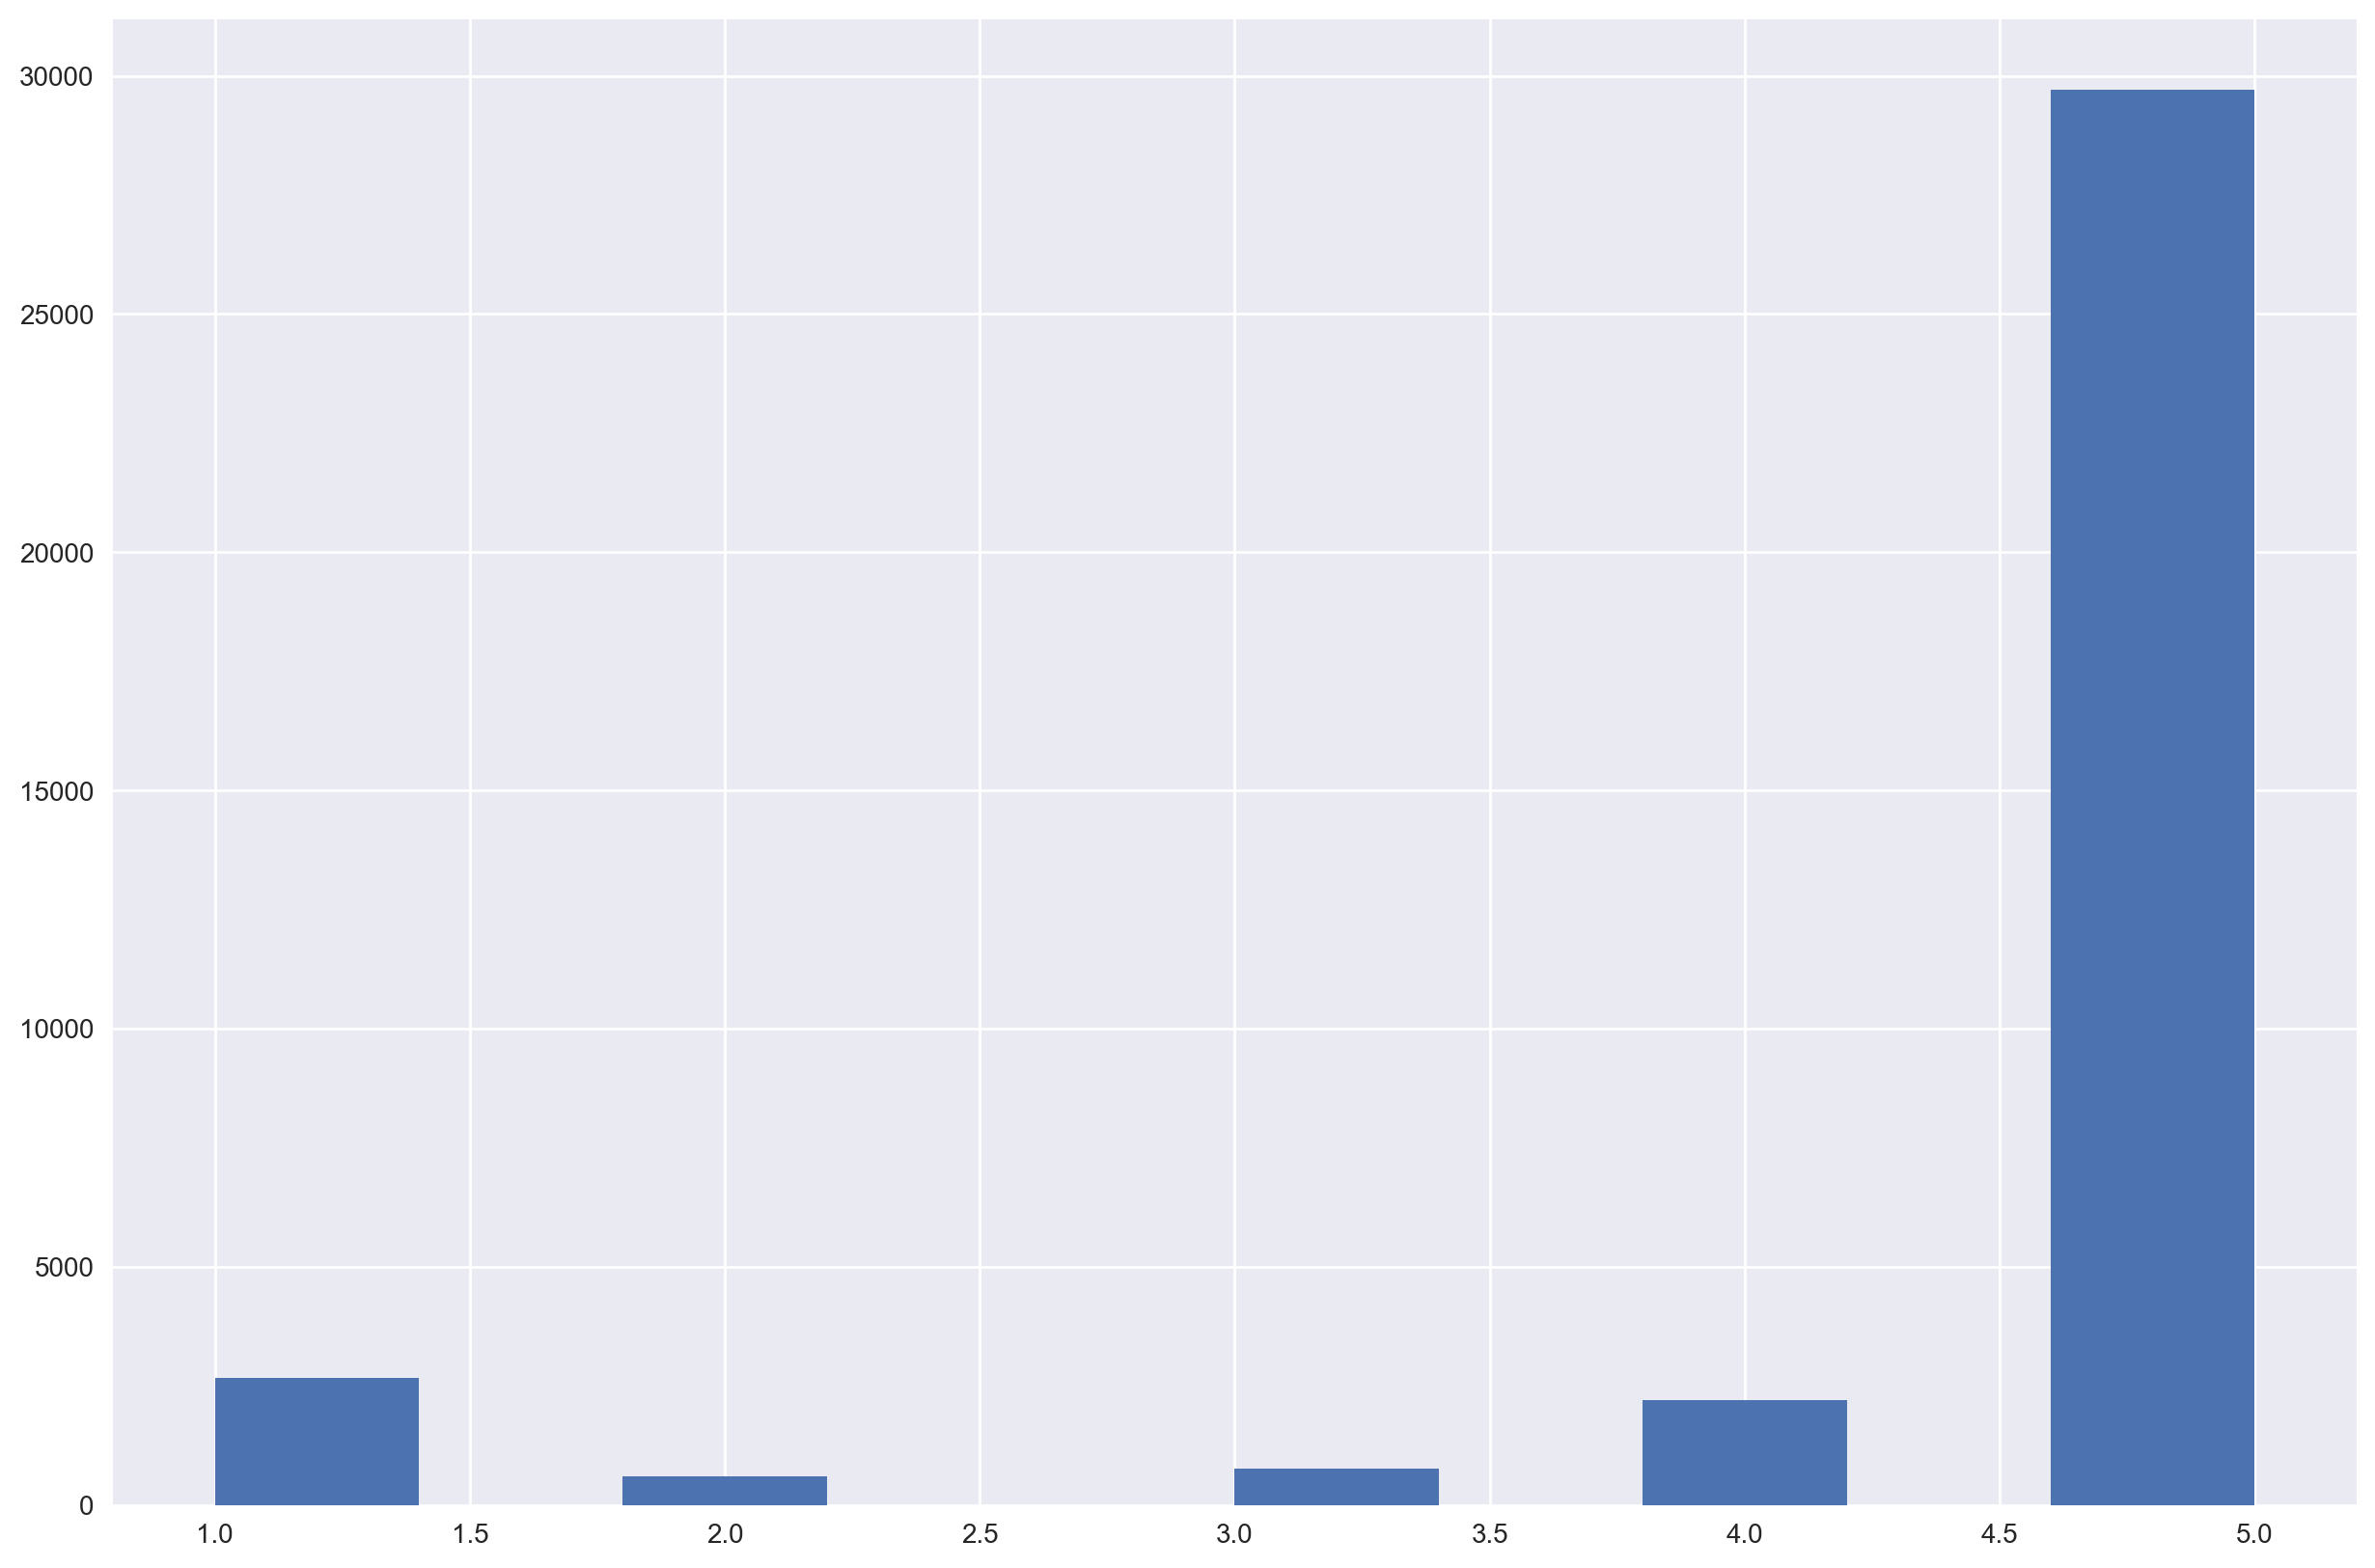

In [16]:
plt.hist(df_hdrev['score'])
plt.show()

## Step 2 - Lower Case the Content

In [17]:
# Lower casing


# Change the reviews type to string
df_hdrev['content'] = df_hdrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_hdrev['content'])

0                                                                                                                                          Dokternya baik dan ramah.
1                                                                                                                                                      Cukup membatu
2                                                                                                                                     Sangat penting dan di butuhkan
3                                                                                                                                                               Good
4                                                                                                                                                               Good
                                                                                    ...                                                                             
35926     

In [47]:
#Lowercase all reviews to see the difference
df_hdrev['content']= df_hdrev['content'].apply(lambda x: x.lower())
df_hdrev['content']

0                                                                                                                                          dokternya baik dan ramah.
1                                                                                                                                                      cukup membatu
2                                                                                                                                     sangat penting dan di butuhkan
3                                                                                                                                                               good
4                                                                                                                                                               good
                                                                                    ...                                                                             
35926     

In [19]:
# Analyze the content statistic
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_hdrev['wordCount'] = [len(review.split()) for review in df_hdrev['content']]

df_hdrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_hdrev['content']]

df_hdrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_hdrev['content']]

In [20]:
#Select only the relevant column
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       score  sentiment_polarity  sentiment_subjective  wordCount  \
0          5            0.000000                   0.0          4   
1          5            0.000000                   0.0          2   
2          5            0.000000                   0.0          5   
3          5            0.700000                   0.6          1   
4          4            0.700000                   0.6          1   
...      ...                 ...                   ...        ...   
35926      5            0.563333                   1.0          5   
35927      5            0.000000                   0.0         20   
35928      5            0.700000                   0.6          2   
35929      5            0.000000                   0.0          4   
35930      5            0.000000                   0.0          8   

       uppercaseCharCount  specialCharCount  
0                       0                 1  
1                       0                 0  
2                       0                 0  
3                       0                 0  
4                       0                 0  
...                   ...               ...  
35926                   0                 1  
35927                   0                 5  
35928                   0                 0  
35929                   0                 0  
35930                   0                 3  

[35931 rows x 7 columns]

In [50]:
#Select only the relevant column
df_hdrev['score'].value_counts()

score
5    29710
1     2664
4     2201
3      755
2      601
Name: count, dtype: int64

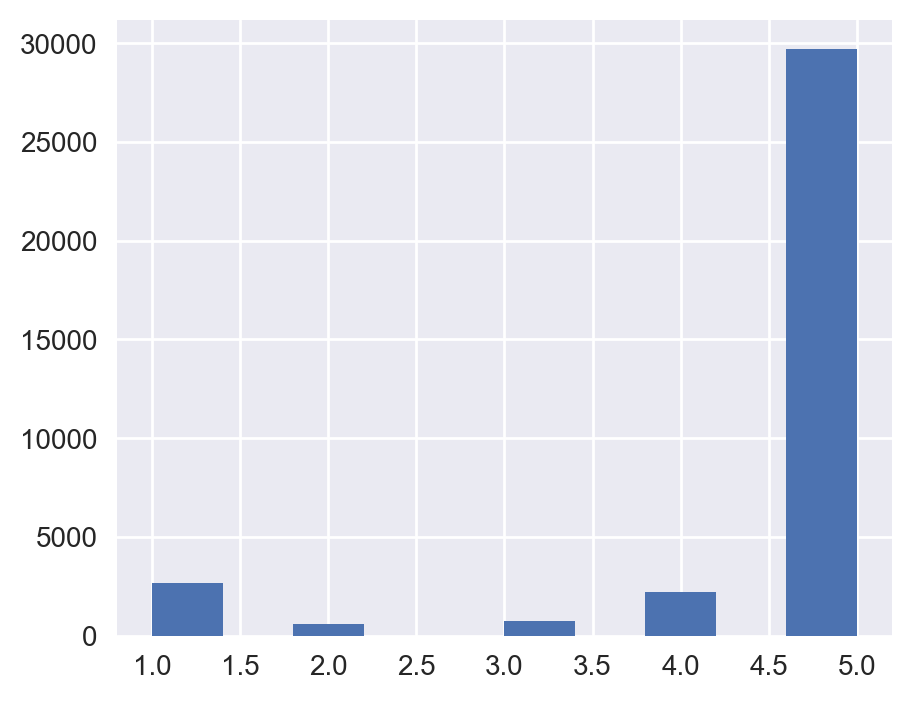

In [51]:
# Menampilkan review score ke dalam bar chart
plt.figure(figsize=[5,4])
plt.hist(df_hdrev['score'])
plt.show()

## Step 3 - Remove Special Characters (Emoji)

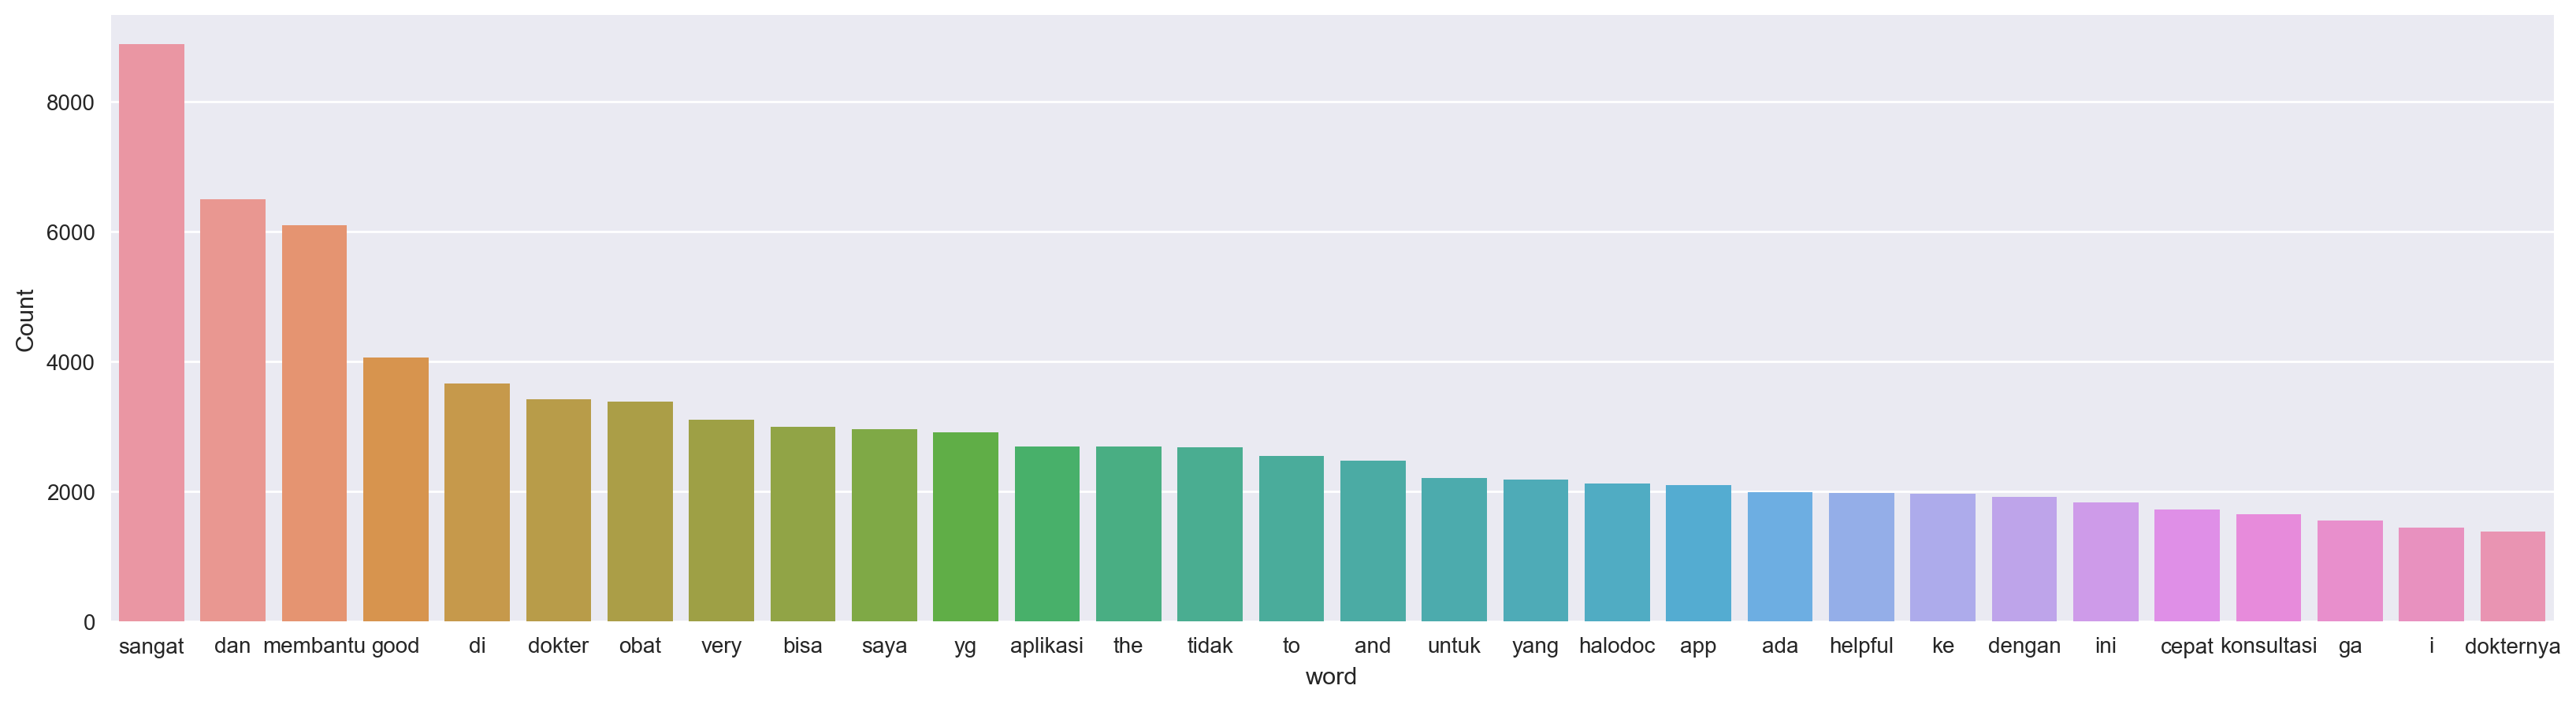

In [23]:
freq_words(df_hdrev['content'])

In [52]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_hdrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_hdrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👎', '👎', '👎']", '[]', '[]', '[]', "['😭']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙏', '🏻']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙄']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", '[]', '[]', '[]', "['😍', '🥰']", "['😊', '👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😇']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😍']", '[]', '[]', '[]', '[]

## Step 4 - Apply Sentiment Rating

In [31]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_hdrev['sentiment_rating'] = df_hdrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [32]:
df_hdrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       score  sentiment_polarity  sentiment_subjective sentiment_rating  
0          5            0.000000                   0.0         Positive  
1          5            0.000000                   0.0         Positive  
2          5            0.000000                   0.0         Positive  
3          5            0.700000                   0.6         Positive  
4          4            0.700000                   0.6         Positive  
...      ...                 ...                   ...              ...  
35926      5            0.563333                   1.0         Positive  
35927      5            0.000000                   0.0         Positive  
35928      5            0.700000                   0.6         Positive  
35929      5            0.000000                   0.0         Positive  
35930      5            0.000000                   0.0         Positive  

[35931 rows x 5 columns]

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


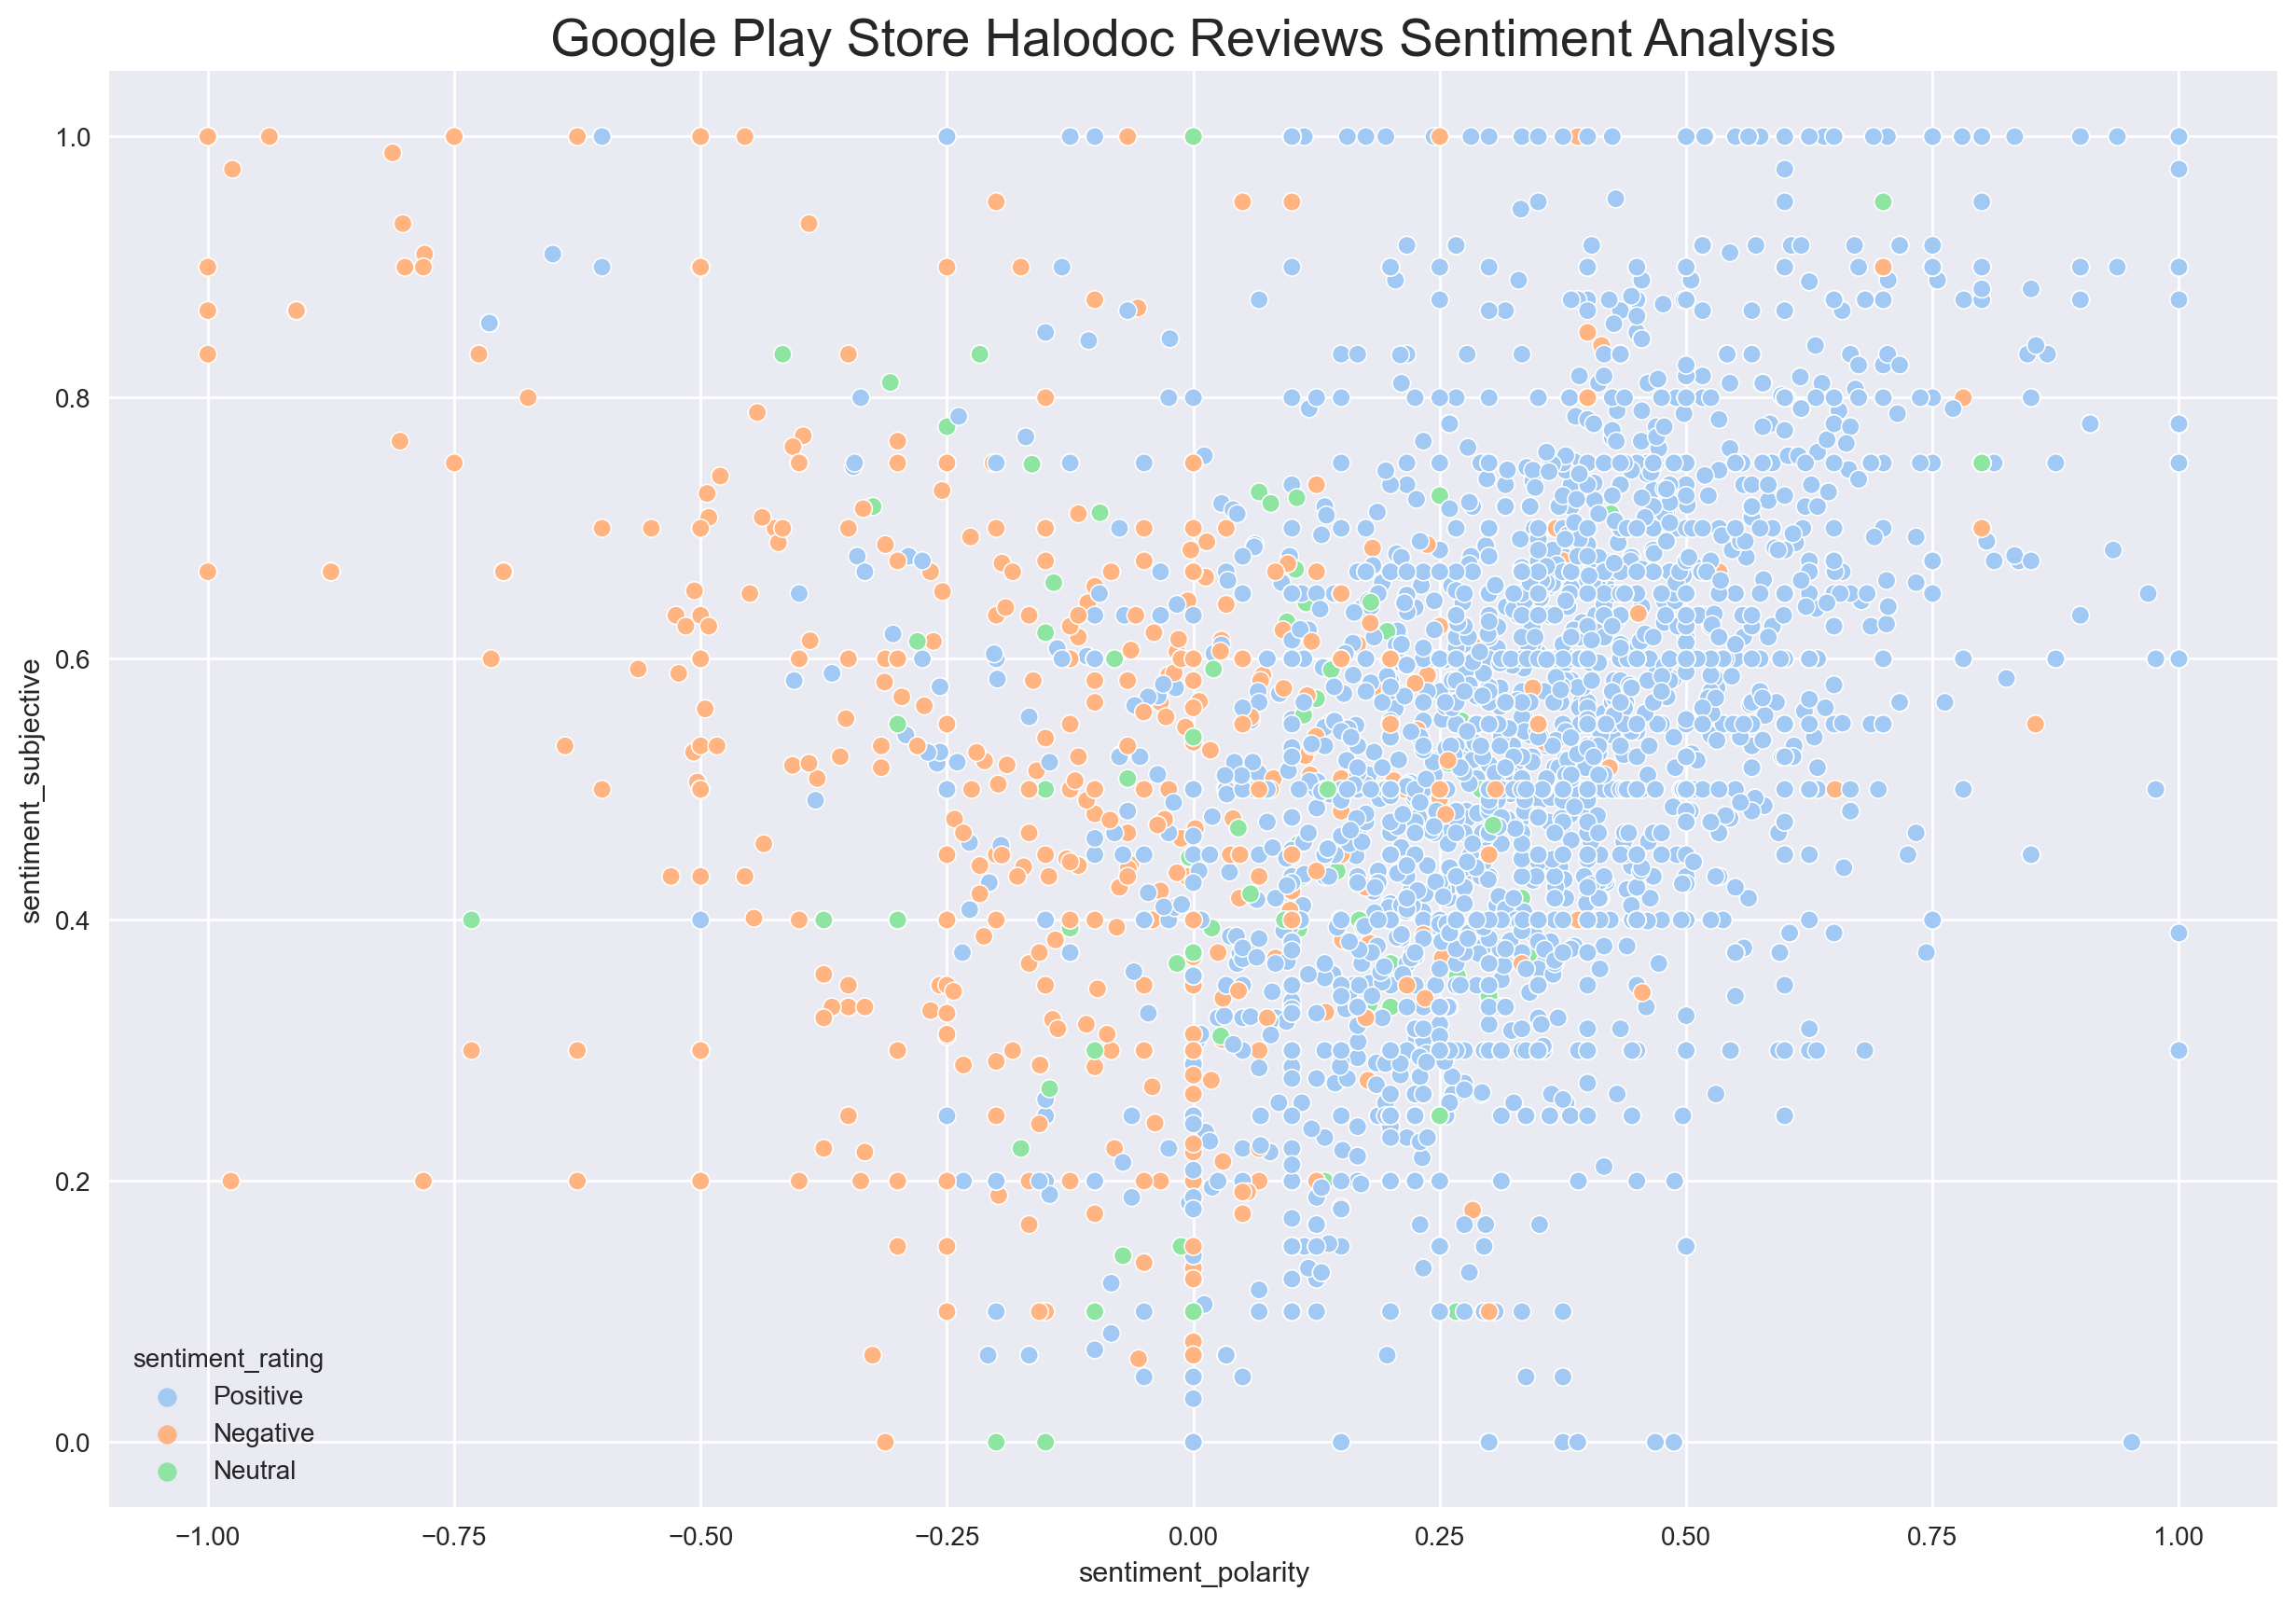

In [54]:
# Import library matplotlib dan seaborn untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Buat figure dengan ukuran 15x10
plt.figure(figsize=(15, 10))

# Buat scatter plot untuk menganalisis sentimen review Halodoc di Google Play Store
# - x-axis: Sentiment Polarity
# - y-axis: Sentiment Subjective
# - hue: Sentiment Rating (warna berbeda untuk setiap rating)
# - edgecolor: Warna tepi titik (putih)
# - palette: Warna pastel untuk visualisasi yang lebih menarik
sns.scatterplot(df_hdrev['sentiment_polarity'], df_hdrev['sentiment_subjective'],
                hue = df_hdrev['sentiment_rating'], edgecolor='white', palette="pastel")

# Tambahkan judul plot
plt.title("Google Play Store Halodoc Reviews Sentiment Analysis", fontsize=20)

# Tampilkan plot
plt.show()

Dari scatter plot analisis sentimen dari ulasan Halodoc di Google Play Stor didapatkan penjelasan :

- **Sumbu X (sentiment_polarity)**: Menunjukkan polaritas sentimen dari ulasan, dengan nilai berkisar dari -1 (sangat negatif) hingga 1 (sangat positif). Nilai mendekati 0 menunjukkan sentimen netral.

- **Sumbu Y (sentiment_subjective)**: Menunjukkan tingkat subjektivitas dari ulasan, dengan nilai berkisar dari 0 (sangat objektif) hingga 1 (sangat subjektif).

- **Warna Titik (sentiment_rating)**:
  - **Biru (Positive)**: Menunjukkan ulasan dengan sentimen positif.
  - **Oranye (Negative)**: Menunjukkan ulasan dengan sentimen negatif.
  - **Hijau (Neutral)**: Menunjukkan ulasan dengan sentimen netral.


## Step 4 - Case Folding and Cleaning Text (Remove Another Special Text) 

In [84]:
#function for counting words in halodoc reviews
def word_count(text: str) -> int:
  return len(text.split())

In [85]:
#make a new df that saved df_hdrev['content'] value to make a comparison 
df_hdrev2 = df_hdrev[['content']].copy()
df_hdrev2['n_words'] = df_hdrev['content'].apply(word_count)

In [86]:
import re
import string

def cleaning_text(text):
  # Menambah spasi setelah koma pada koma yang tidak diberi spasi
  text = re.sub(r",(?!\s)", ", ", text)
  # Menghapus tab, new line, back slice, dll
  text = text.replace('\\t', " ").replace('\\n', " ").replace('\\u', " ").replace('\\', "")
  # Menghapus karakter non ASCII (emoticon, chinese word, dll),
  text = text.encode('ascii', 'replace').decode('ascii')
  # Menghapus URL
  text = re.sub(r"(?i)(?:https?:\/\/)?(?:www\.)?(?:[a-zA-Z0-9-.]+)(?:\.[a-zA-Z]{2,6})(?:\/[^\s\r\n]*)?", "", text)
  # Menghapus angka
  text = re.sub(r"\d+", "", text)
  # Menghapus tanda baca
  text = text.translate(str.maketrans("", "", string.punctuation))
  # Menghapus whitespace di depan/belakang teks dan double++ spasi
  text = text.strip()
  text = re.sub('\s+', ' ', text)
  # Menghapus single character
  return re.sub(r"\b[a-zA-Z]\b", "", text)

In [87]:
df_hdrev2['clean'] = df_hdrev2['content'].apply(cleaning_text)
df_hdrev2['count_clean'] = df_hdrev2['clean'].apply(word_count)

In [88]:
#Print the clean review column (content) before stopwords
df_hdrev2.to_csv(r'df_halodoc_before_stopwords_sentiment_rating.csv', index=False)

## Step 5 - Exploratory before Stopwords

In [89]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [90]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

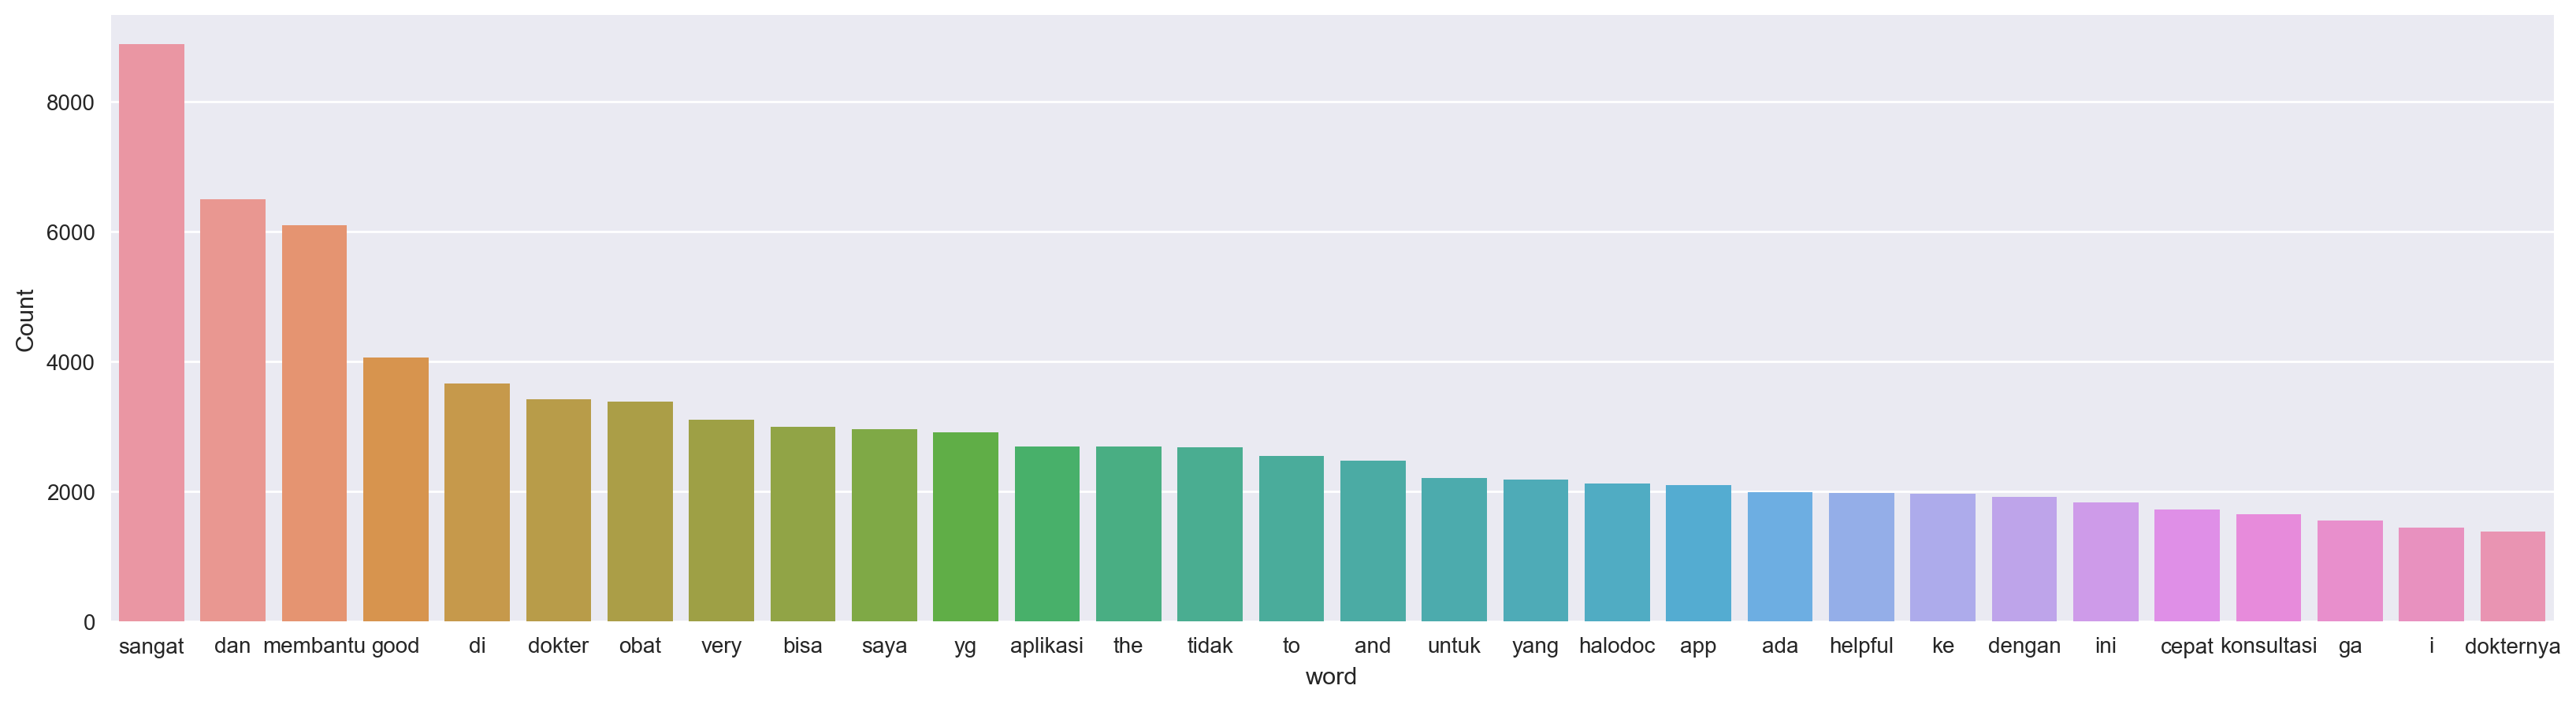

In [91]:
freq_words(df_hdrev2['content'])

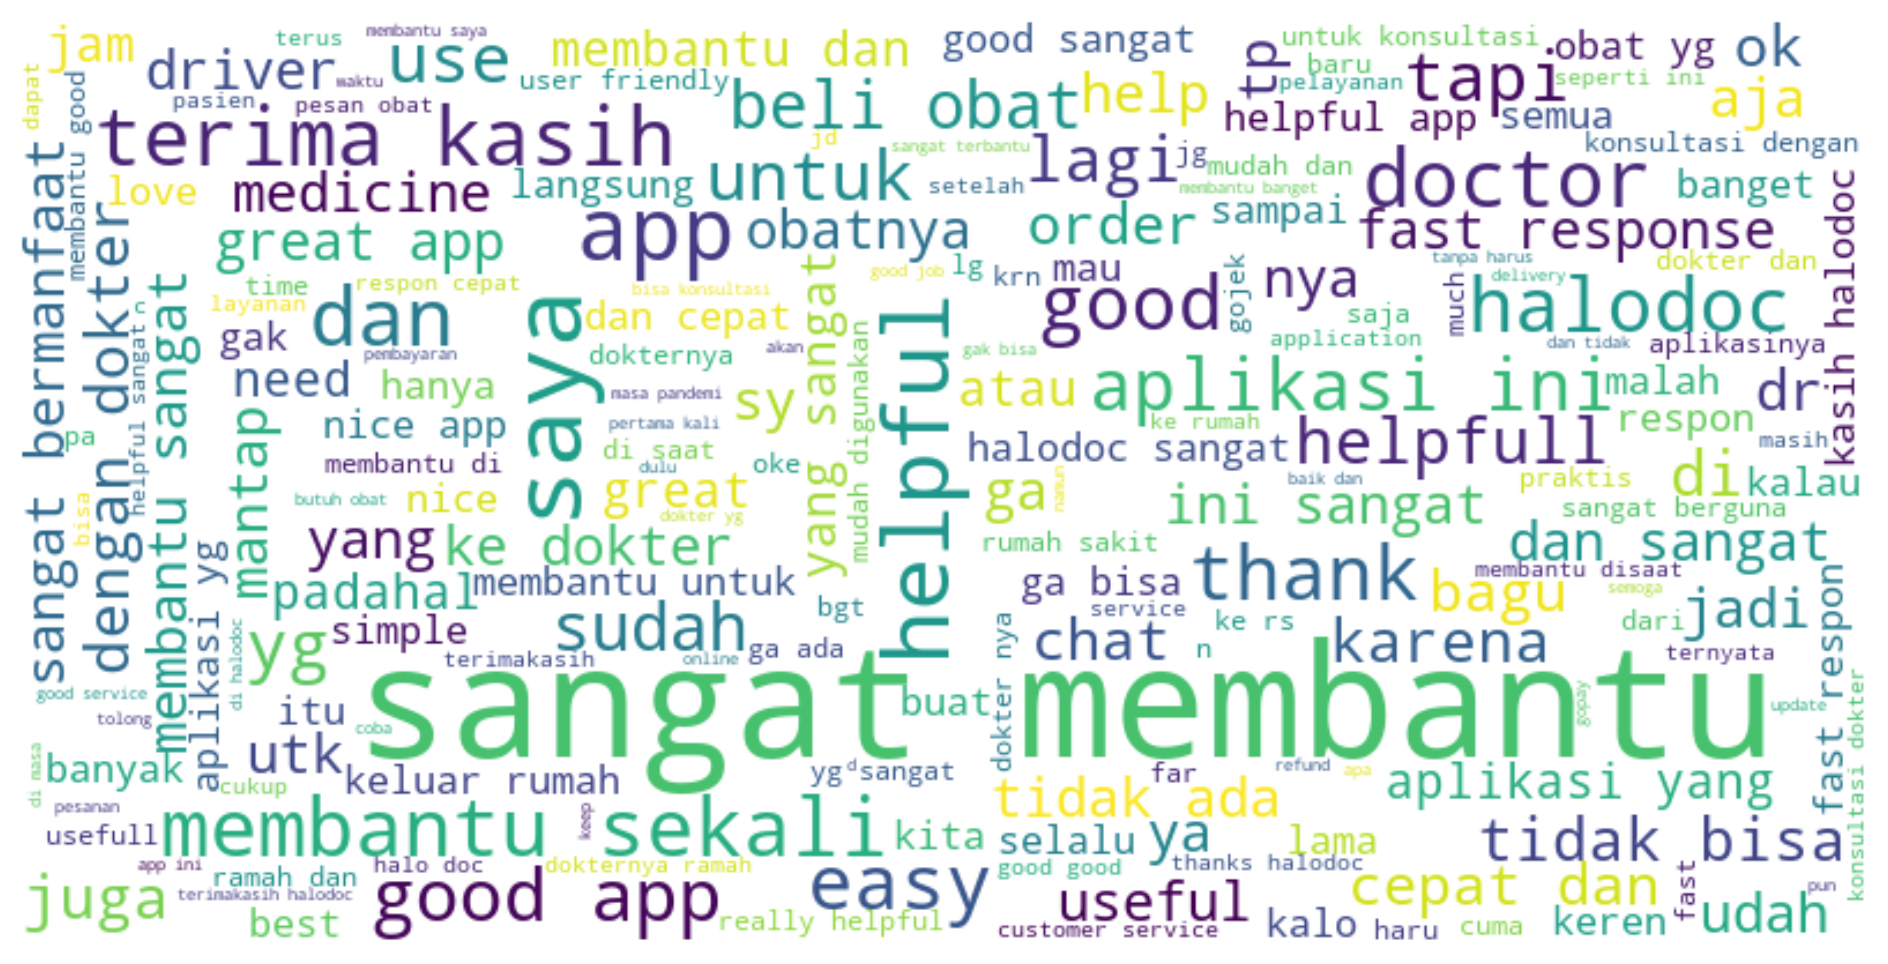

In [92]:
# Join all of the words in the 'content' in one string
all_words_before = ' '.join(df_hdrev2['content'])

# WordCloud before removing stopwords
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()

## Step 6 - Tokenizing

In [94]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
# Tokenize the 'cleaned_text' column
df_hdrev2['token'] = df_hdrev2['content'].apply(word_tokenize)

# Display the DataFrame with the tokens
display(df_hdrev2[['content', 'token']])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

                                                                                                                                                                                        token  
0                                                                                                                                                            [dokternya, baik, dan, ramah, .]  
1                                                                                                                                                                            [cukup, membatu]  
2                                                                                                                                                        [sangat, penting, dan, di, butuhkan]  
3                                                                                                                                                                                      [good]  
4                                                                                                                                                                                      [good]  
...                                                                                                                                                                                       ...  
35926                                                                                                                                                      [it, 's, very, easy, and, helpful]  
35927  [sepertinya, ini, aplikasi, pertama, di, indonesia, .., yg, menghubungkan, online, dg, dokter, .., memudahkan, mendapat, informasi, permasalahan, kesehatan, dg, sumber, yg, tepat, .]  
35928                                                                                                                                                                      [good, aplication]  
35929                                                                                                                                                           [this, is, simplying, health]  
35930                                             

## Step 7 - Normalization

In [98]:
normalized_word = pd.read_csv("C:/Users/User/Jupyter Notebook/PBA/Analisis Sentimen Halodoc/resource/normalisasi.csv", encoding = 'latin1')

normalized_word_dict = {}
for index, row in normalized_word.iterrows():
  if row[0] not in normalized_word_dict:
    normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
  return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_hdrev2['normalisasi'] = df_hdrev2['token'].apply(normalized_term)
df_hdrev2

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       n_words  \
0            4   
1            2   
2            5   
3            1   
4            1   
...        ...   
35926        5   
35927       20   
35928        2   
35929        4   
35930        8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah sendiri   

       count

## Remove Stopwords

In [100]:
#remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword = stopwords.words('indonesian')
txt_stopword = pd.read_csv("C:/Users/User/Jupyter Notebook/PBA/Analisis Sentimen Halodoc/resource/indonesian-stopwords-complete.txt", names = ["stopwords"], header = None)

stopword.extend(["nya", "oke", "ada", "nih", "ni", "kenapa", "wkwk", "pagi", "alasan", "biar", "eh"])

stopword.extend(txt_stopword["stopwords"][0].split(' '))
stopword = set(stopword)

def stopwords(text):
  text = [word for word in text if word not in stopword]
  return text
df_hdrev2['Stopwords'] = df_hdrev2['normalisasi'].apply(stopwords)
df_hdrev2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       n_words  \
0            4   
1            2   
2            5   
3            1   
4            1   
...        ...   
35926        5   
35927       20   
35928        2   
35929        4   
35930        8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah sendiri   

       count

In [105]:
#analisis frekuensi kata dari kolom Stopwords
from nltk import FreqDist
from collections import Counter

def freq_words(x, terms=30):
    # Flatten the list of lists
    all_words = [word for sublist in x for word in sublist]
    
    # Hitung frekuensi kata
    fdist = FreqDist(all_words)
    
    # Kembalikan kata-kata yang paling sering muncul
    return fdist.most_common(terms)

# Gunakan fungsi untuk menganalisis frekuensi kata
hasil_frekuensi = freq_words(df_hdrev2['Stopwords'])

# Tampilkan hasil
print(hasil_frekuensi)

[('.', 18241), (',', 14948), ('membantu', 7498), ('good', 4359), ('dokter', 4036), ('obat', 4011), ('!', 3421), ('..', 3352), ('halodoc', 3187), ('very', 3140), ('app', 2925), ('aplikasi', 2834), ('the', 2701), ('to', 2558), ('helpful', 2524), ('and', 2493), ('cepat', 2407), ('banget', 1801), ('terima kasih', 1797), ('konsultasi', 1784), ('...', 1745), ('i', 1589), ('dokternya', 1532), ('apps', 1403), ('bagus', 1383), ('mudah', 1292), ('chat', 1264), ('kasih', 1259), ('it', 1230), ('this', 1195)]


In [103]:
import pandas as pd

# Ubah hasil menjadi DataFrame
df_frekuensi = pd.DataFrame(hasil_frekuensi, columns=['Kata', 'Frekuensi'])

# Tampilkan DataFrame
print(df_frekuensi)

            Kata  Frekuensi
0              .      18241
1              ,      14948
2       membantu       7498
3           good       4359
4         dokter       4036
5           obat       4011
6              !       3421
7             ..       3352
8        halodoc       3187
9           very       3140
10           app       2925
11      aplikasi       2834
12           the       2701
13            to       2558
14       helpful       2524
15           and       2493
16         cepat       2407
17        banget       1801
18  terima kasih       1797
19    konsultasi       1784
20           ...       1745
21             i       1589
22     dokternya       1532
23          apps       1403
24         bagus       1383
25         mudah       1292
26          chat       1264
27         kasih       1259
28            it       1230
29          this       1195


In [120]:
import nltk
import string
from nltk.corpus import stopwords
import pandas as pd

nltk.download('stopwords')
stopword_2 = stopwords.words('indonesian')
txt_stopword = pd.read_csv("C:/Users/User/Jupyter Notebook/PBA/Analisis Sentimen Halodoc/resource/indonesian-stopwords-complete.txt", names = ["stopwords"], header = None)

# Menambahkan stopwords baru
stopword_2.extend(["nya", "oke", "ada", "nih", "ni", "kenapa", "wkwk", "pagi", "alasan", "biar", "eh",
                 "dokter", "obat", "halodoc", "very", "app", "aplikasi", "the",
                 "to", "and", "banget", "konsultasi", "i",
                 "dokternya", "apps", "chat", "it", "this"])

stopword_2.extend(txt_stopword["stopwords"][0].split(' '))
stopword_2 = set(stopword_2)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
# Fungsi untuk menghapus tanda baca
def remove_punctuation(text):
    return [word for word in text if word not in string.punctuation]

# Fungsi untuk menghapus stopwords
def remove_stopwords(text):
    return [word for word in text if word.lower() not in stopword_2]

In [122]:
# Aplikasikan fungsi-fungsi preprocessing
df_hdrev2['no_stopwords'] = df_hdrev2['normalisasi'].apply(remove_punctuation)
df_hdrev2['no_stopwords'] = df_hdrev2['no_stopwords'].apply(remove_stopwords)

# Tampilkan hasil
df_hdrev2[['content','normalisasi', 'no_stopwords']]


content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

                                                                                                                                                                                              normalisasi  \
0                                                                                                                                                                        [dokternya, baik, dan, ramah, .]   
1                                                                                                                                                                                        [cukup, membatu]   
2                                                                                                                                                                    [sangat, penting, dan, di, butuhkan]   
3                                                                                                                                                                                                  [good]   
4                                                                                                                                                                                                  [good]   
...                                                                                                                                                                                                   ...   
35926                                                                                                                                                                  [it, 's, very, easy, and, helpful]   
35927  [sepertinya, ini, aplikasi, pertama, di, indonesia, .., yang, menghubungkan, online, dengan, dokter, .., memudahkan, mendapat, informasi, permasalahan, kesehatan, dengan, sumber, yang, tepat, .]   
35928                                                                                                                                                                                  [good, aplication]   
35929                                                                                                           

In [123]:
# Hitung frekuensi kata setelah preprocessing
from collections import Counter

def freq_words(x, terms=30):
    all_words = [word.lower() for sublist in x for word in sublist]
    word_freq = Counter(all_words)
    return word_freq.most_common(terms)

hasil_frekuensi = freq_words(df_hdrev2['no_stopwords'])

# Tampilkan hasil frekuensi dalam bentuk DataFrame
df_frekuensi = pd.DataFrame(hasil_frekuensi, columns=['Kata', 'Frekuensi'])
df_frekuensi

Kata  Frekuensi
0       membantu       7498
1           good       4359
2             ..       3352
3        helpful       2524
4          cepat       2407
5   terima kasih       1797
6            ...       1745
7          bagus       1383
8          mudah       1292
9          kasih       1259
10          fast       1169
11           for       1167
12        terima       1132
13            so       1080
14        apotek       1078
15      helpfull       1061
16           you       1053
17         sakit        978
18        respon        970
19          easy        955
20            is        951
21         rumah        944
22        doctor        936
23          beli        920
24             a        914
25         great        907
26      langsung        898
27          nice        838
28         pakai        812
29         resep        794

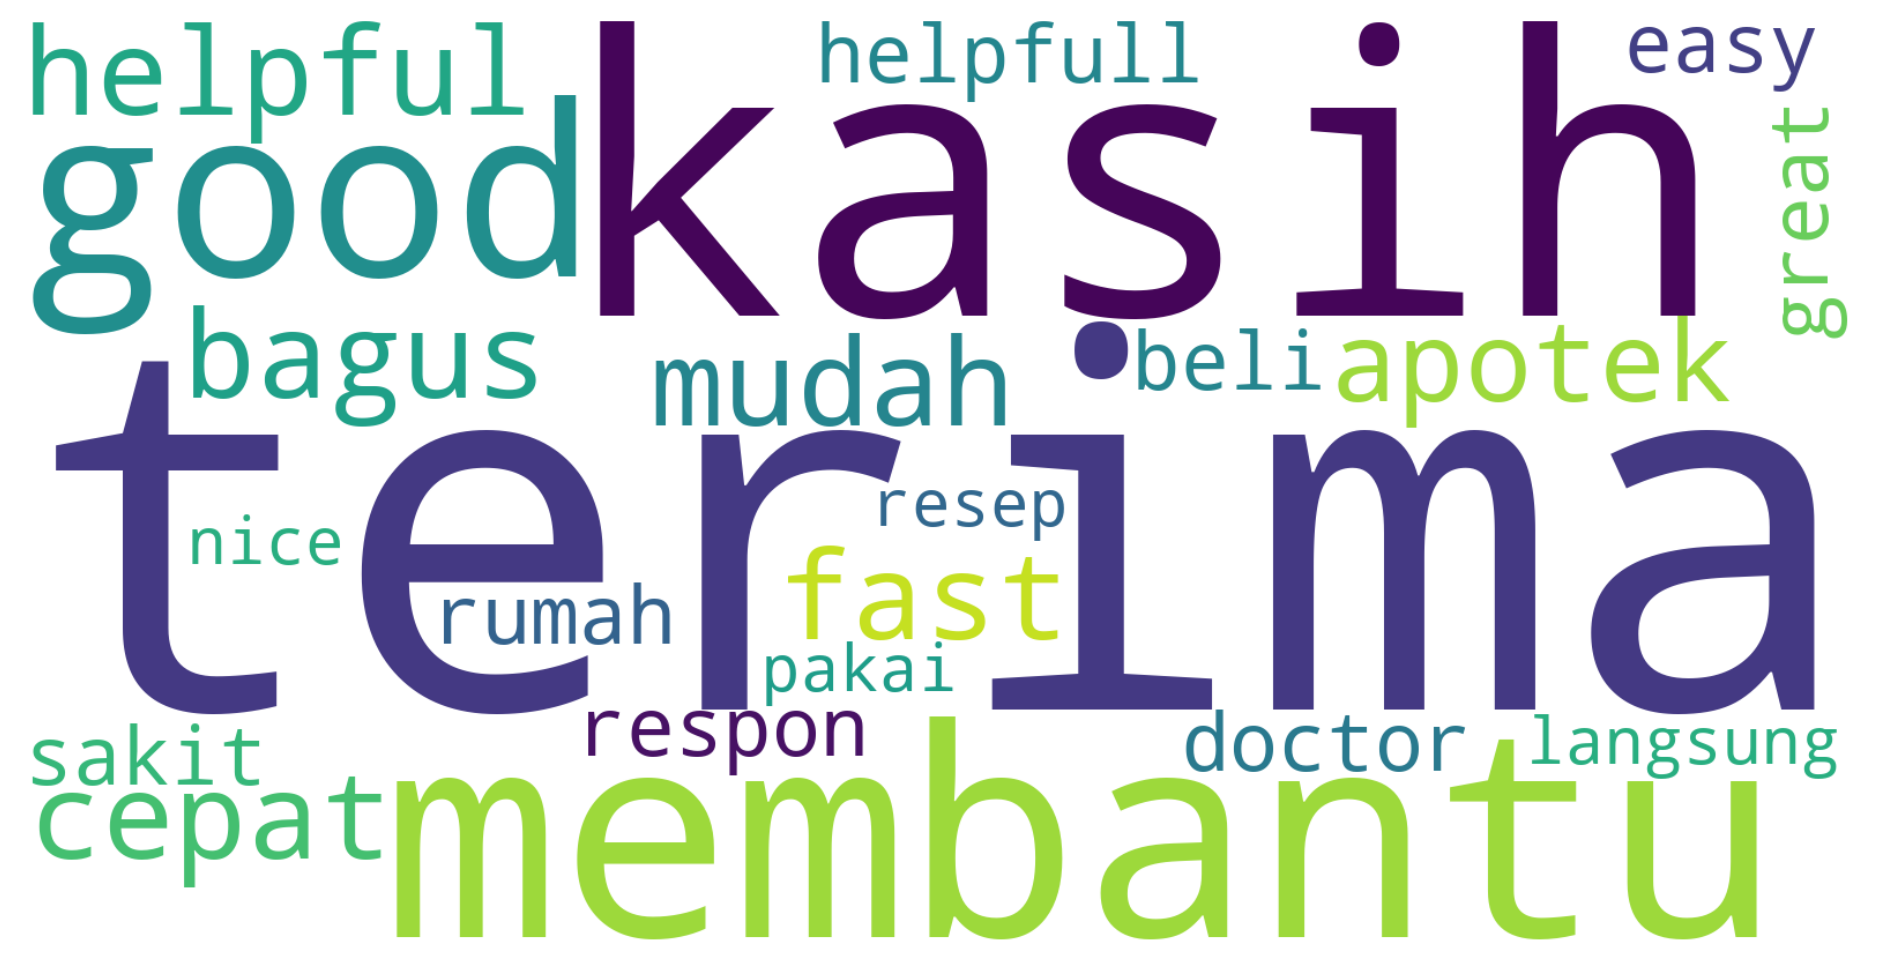

In [129]:
# Join all of the words in the 'content' in one string
all_words_before = ' '.join(df_frekuensi['Kata'])

# WordCloud before removing stopwords
wordcloud_before = WordCloud(width=1600, height=800, background_color='white').generate(all_words_before)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.show()



## Stemming

In [137]:
pip install sastrawi swifter --no-cache-dir

     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.2 MB 217.9 kB/s eta 0:00:06
     -- ------------------------------------- 0.1/1.2 MB 297.7 kB/s eta 0:00:04
     --- ------------------------------------ 0.1/1.2 MB 467.6 kB/s eta 0:00:03
     ---- ----------------------------------- 0.1/1.2 MB 532.5 kB/s eta 0:00:02
     ------ --------------------------------- 0.2/1.2 MB 621.6 kB/s eta 0:00:02
     ----------- ---------------------------- 0.3/1.2 MB 910.2 kB/s eta 0:00:01
     ------------- -------------------------- 0.4/1.2 MB 956.1 kB/s eta 0:00:01
     ------------------ --------------------- 0.6/1.2 MB 1.2 MB/s eta 0:00:01
     --------------------- ------------------ 0.6/1.2 MB 1.3 MB/s eta 0:00:01
     ------------------------ --------------- 0.7/1.2 MB 1.3 MB/s eta 0

In [140]:
#STEMMING

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

factory=StemmerFactory()
stemmer = factory.create_stemmer()

def stemmed_wrapper(term):
  return stemmer.stem(term)

term_dict = {}

tweet = df_hdrev2['no_stopwords']
for doc in tweet:
      for term in doc:
        if term not in term_dict:
          term_dict[term]=' '
      print(len(term_dict))
      print("-------------------------")

for term in term_dict:
  term_dict[term] = stemmed_wrapper(term)
  print(term,":",term_dict[term])

print(len(term_dict))
print("-------------------------")
     

1
-------------------------
2
-------------------------
3
-------------------------
4
-------------------------
4
-------------------------
12
-------------------------
12
-------------------------
15
-------------------------
16
-------------------------
17
-------------------------
19
-------------------------
24
-------------------------
28
-------------------------
31
-------------------------
35
-------------------------
41
-------------------------
42
-------------------------
81
-------------------------
81
-------------------------
82
-------------------------
82
-------------------------
85
-------------------------
93
-------------------------
98
-------------------------
103
-------------------------
113
-------------------------
115
-------------------------
121
-------------------------
132
-------------------------
133
-------------------------
133
-------------------------
133
-------------------------
134
-------------------------
140
-------------------------
148
-----

-------------------------
13012
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13014
-------------------------
13016
-------------------------
13016
-------------------------
13016
-------------------------
13017
-------------------------
13019
-------------------------
13020
-------------------------
13020
-------------------------
13020
-------------------------
13020
-------------------------
13020
-------------------------
13021
-------------------------
13021
-------------------------
13021
-------------------------
13021
-------------------------
13022
-------------------------
13022
-------------------------
13022
-------------------------
13023
-------------------------
13023
-------------------------
13023
-------------------------
13023
-------------------------
13023
--------

good : good
membantu : bantu
berobat : obat
repot : repot
antre  : antre
berurusan : urus
administrasi : administrasi
rumah : rumah
sakiy : sakiy
helpful : helpful
super : super
recommended : recommended
helpfull : helpfull
pembelian : beli
fast : fast
reliable : reliable
bermanfaat : manfaat
halo : halo
dok : dok
terima : terima
kasih : kasih
helps : helps
me : me
be : be
kind : kind
problem : problem
pengiriman : kirim
👎👎👎 : 
seneng : neng
layanan : layan
hewan : hewan
terbantu : bantu
interaktif : interaktif
pemesanan : mesan
mudah : mudah
... : 
semoga : moga
berkembang : kembang
hebat : hebat
parah : parah
bangettt : bangettt
sih : sih
nyariin : nyariin
Apotek : apotek
jauhnya : jauh
kebangetan : banget
😭 : 
temenku : temenku
langganan : langgan
rumahnya : rumah
bogor : bogor
depok : depok
driver : driver
ngcancel : ngcancel
wajar : wajar
malam : malam
diatas : atas
jam : jam
11 : 11
malem : malem
pas : pas
ngecek : ngecek
tarif : tarif
gojek : gojek
83rb : 83rb
dapet : dapet
22rb

prevent : prevent
wrong : wrong
diagnose : diagnose
by : by
nice : nice
status : status
barang : barang
diterima : terima
keluarga : keluarga
jujur : jujur
foto : foto
info : info
wa : wa
solve : solve
disuruh : suruh
tunggu : tunggu
7 : 7
jualan : jual
celana : celana
jeans : jeans
kecewa : kecewa
heran : heran
apotiknya : apotik
jauuuh : jauuuh
posisi : posisi
jaksel : jaksel
dapetnya : dapetnya
tangsel : tangsel
bekasi : bekas
user : user
friendly : friendly
top : top
aplikasinya : aplikasi
penjelasan : jelas
pahami : paham
first : first
bangeeeet : bangeeeet
😍 : 
terharu : haru
akuuu : akuuu
sehari2 : sehari2
ramah2 : ramah2
ahli : ahli
menyenangkan : senang
respons : respons
anak : anak
sama² : sama
practical : practical
satisfied : satisfied
pamulang : pamulang
rekomendasi : rekomendasi
terdekatnya : dekat
thankyou : thankyou
ulasan : ulas
sayang : sayang
daftar : daftar
tersedia : sedia
update : update
contoh : contoh
toko : toko
2 : 2
dana : dana
hangus : hangus
direfund : dire

backend : backend
merugikan : rugi
eropa : eropa
luamaaaaa : luamaaaaa
appointment : appointment
berpengalaman : alam
handal : handal
valid : valid
penilaiannya : nilai
or : or
stok : stok
kosong : kosong
kembalikan : kembali
cash : cash
harunya : haru
dintanyakan : dintanyakan
ribet : ribet
terpercaya : percaya
pesan2 : pesan2
bug : bug
delay : delay
60 : 60
pertolongam : pertolongam
mempermudah : mudah
baikkk : baikkk
apalg : apalg
skr : skr
link : link
pembyrn : pembyrn
diambil : ambil
alih : alih
phk : phk
dokter-dokternya : dokter
dicover : dicover
sistemnya : sistem
konsult : konsult
digital : digital
end : end
convertation : convertation
nuduh2 : nuduh2
bad : bad
pelayanamnya : pelayanamnya
efisien : efisien
naiseeee : naiseeee
penjamin : jamin
informasi : informasi
tanggung : tanggung
rawat : rawat
inap : inap
benefit : benefit
makanan : makan
pendamping : damping
dikenakan : kena
nilainya : nilai
kesalahan : salah
membayar : bayar
namanya : nama
menjebak : jebak
wowo : wowo
ku

basically : basically
mining : mining
operation : operation
beware : beware
niat : niat
dih : dih
kocak : kocak
mencari : cari
membntu : membntu
fleksibel : fleksibel
paru : paru
ayudiah : ayudiah
banget😭🤌🫶🫶🫶 : banget
notif : notif
onlen : onlen
kek : kek
cape : cape
ketinggalan : tinggal
las : las
full : full
offline😭 : offline
diupdate : diupdate
membantuuuu : membantuuuu
😍😍😍😍 : 
seringkali : seringkali
memantau : pantau
kirimnya : kirim
kurirnya : kurir
t_t : t t
balesnya : balesnya
lupa : lupa
appnya : appnya
diselesaikan : selesai
hadeh : hadeh
menyimpulkan : simpul
singkat2 : singkat2
nyimpulin : nyimpulin
anehh : anehh
kasi : kasi
rate : rate
ketauan : tau
engga : engga
want : want
waste : waste
money : money
worst : worst
case : case
awal-awal : awal
bagus-bagus : bagus
trouble : trouble
masuk-masuk : masuk
kwitansi : kwitansi
diklaim : klaim
segi : segi
sebenernya : sebenernya
performa : performa
uninstall : uninstall
emergencies : emergencies
add : add
select : select
store :

dyah : dyah
sawitri : sawitri
ari : ari
santi : santi
gianyar : gianyar
tlng : tlng
ditindaklanjuti : ditindaklanjuti
bukti : bukti
pembicaraan : bicara
sampah : sampah
12 : 12
telpon2 : telpon2
diangkat : angkat
tidur : tidur
ditunggu : tunggu
molor : molor
illfeel : illfeel
ditahan : tahan
bugging : bugging
had : had
phone : phone
decide : decide
nearest : nearest
pharm : pharm
-_- : - -
ketahuan : tahu
ngirim : ngirim
diapa : apa
apain : apain
ux : ux
hassles : hassles
why : why
integrate : integrate
into : into
food : food
reponsif : reponsif
worse : worse
8 : 8
estimasikan : estimasi
direspon : direspon
jelk : jelk
........ : 
coverall : coverall
dilegalkan : legal
pastikan : pasti
keterangan : terang
hisap : hisap
dipertanggungjawabkan : dipertanggungjawabkan
stempel : stempel
terkait : kait
serious : serious
pikir : pikir
anabul : anabul
adq : adq
u/ : u
kaum2 : kaum2
introvert : introvert
keq : keq
gw : gw
sigap : sigap
dialami : alami
sippp : sippp
mengcover : mengcover
golong

color : color
item : item
hapus : hapus
samsung : samsung
m33 : m33
security : security
terkini : kini
ya🤔 : ya
istirahat : istirahat
pencarian : cari
penerima : terima
galau : galau
bawa : bawa
kredible : kredible
tumbuh : tumbuh
kembang : kembang
sebentar : sebentar
30menit : 30menit
balasnya : balas
cepaaat : cepaaat
andelin : andelin
tpi : tpi
bales : bales
penerimanya : terima
tertulis : tulis
pemilik : milik
ngotot : ngotot
dikenal : kenal
eka : eka
rumisha : rumisha
sedia : sedia
sakitny : sakitny
mengantri : antri
rs/klinik : rs klinik
🫰❤️ : 
connection : connection
discussion : discussion
responses : responses
medicines : medicines
6 : 6
ngehang : ngehang
terbiasa : biasa
membiasakan : biasa
kedepannya : depan
dokter²nya : dokter nya
bingung : bingung
ratingnya : ratingnya
lemas : lemas
menceritakan : cerita
gejala : gejala
dirasakan : rasa
untun : untun
berkilo : kilo
kilo : kilo
bandung : bandung
gigi : gigi
intuitif : intuitif
luarbiasa : luarbiasa
mantaapp : mantaapp
obat²

usually : usually
access : access
cart : cart
meds : meds
necessary : necessary
function : function
practically : practically
unusable : unusable
nowadays : nowadays
shame : shame
kepastiannya : pasti
berlaku : laku
administrasinya : administrasi
concern : concern
keterbatasan : batas
message : message
chatroom : chatroom
jadwal : jadwal
ditetapkan : tetap
transaksinya : transaksi
deg2an : deg2an
beneran : beneran
ato : ato
u : u
♡ : 
kesulitan : sulit
memebantu : bantu
jam2 : jam2
ramah🙏🏻☺ : ramah
anggota : anggota
berkurang : kurang
tdak : tdak
easily : easily
prescribed : prescribed
mengantarkan : antar
12.000. : 12 000
blom : blom
nongol : nongol
siy : siy
disiapkan : siap
dikasih : kasih
resinya : resi
sore : sore
tunya : tunya
perumahan : rumah
rekomen : rekomen
menyelesaikan : selesai
baik.saya : baik saya
pcs : pcs
yabg : yabg
pcs,4 : pcs 4
hilang.saya : hilang saya
komplain.dan : komplain dan
hari.halodoc : hari halodoc
solusi.tentabg : solusi tentabg
unggah : unggah
ujung-uju

akhir2ini : akhir2ini
ekonomis : ekonomis
rmh : rmh
tnp : tnp
alot : alot
someone : someone
alone : alone
energy : energy
receipt : receipt
duper : duper
sejam : jam
insurances : insurances
server : server
hallodoc : hallodoc
ke.kuar : ke kuar
terbukti : bukti
jis : jis
najis : najis
sampe2 : sampe2
kelewatan : lewat
angkat2 : angkat2
ditolak : tolak
jebakan : jebak
batman : batman
model : model
bisnisnya : bisnis
nolak : nolak
screening : screening
calon : calon
customernya : customernya
eligible : eligible
manfaatin : manfaatin
asuransinya : asuransi
tagih : tagih
ckckckckck : ckckckckck
lamban : lamban
sitem : sitem
kenyataannya : nyata
😭👍🏻 : 
kesambung : sambung
taunya : tau
awal2 : awal2
gps : gps
simpan : simpan
palembang : palembang
tangerang : tangerang
menjangkau : jangkau
50k : 50k
lmao : lmao
aplikasj : aplikasj
compatible : compatible
kayanya : kaya
slowrespond : slowrespond
🤦 : 
dibenerin : dibenerin
alwayssssss : alwayssssss
kami. : kami
obat. : obat
pondok : pondok
pesan

automatic : automatic
glitch : glitch
friend : friend
find : find
dahh : dahh
sakitnya : sakit
notifnya : notifnya
syukur : syukur
berhasil : hasil
coba2 : coba2
3-4 : 3-4
eta : eta
mind : mind
contacting : contacting
incomplete : incomplete
items : items
happens : happens
either : either
track : track
stocks : stocks
tools : tools
nihil : nihil
nyaut : nyaut
acan : acan
cus : cus
igd : igd
trust : trust
lhoh : lhoh
validasi : validasi
sampai/tidak : sampai tidak
works : works
thanks.membantu : thanks bantu
optimal : optimal
thanka : thanka
post : post
pil : pil
nikah : nikah
keempat : empat
dibolehin : dibolehin
120k : 120k
malu : malu
promosikan : promosi
kondom : kondom
bebas : bebas
medsos : medsos
dibaca : baca
anak² : anak
menimbulkan : timbul
sex : sex
kalangan : kalang
moral : moral
pisannnn : pisannnn
jelasss : jelasss
pisan : pis
19 : 19
terkonfirmasi : konfirmasi
dianggap : anggap
informas : informas
tertampil : tampil
singkron : singkron
gracefully : gracefully
accommodatin

susah2 : susah2
kemacetan : macet
dikurangi : rang
dihandalkan : dihandalkan
berulangkali : berulangkali
dgb : dgb
terjelek : jelek
bli : bli
cpet : cpet
fake : fake
jamman : jamman
mpe : mpe
kiamat : kiamat
cowok : cowok
tololnya : tolol
ngedetect : ngedetect
gbsa : gbsa
dsuruh : dsuruh
ladang : ladang
bisnis😭 : bisnis
gmnlagi : gmnlagi
yaahh😭😭😭 : yaahh
daring : daring
antri2 : antri2
16.411 : 16 411
dmna : dmna
pdahal : pdahal
kelar : kelar
udhin : udhin
okkkk : okkkk
terbagi : bagi
satunya : satu
dissapointed : dissapointed
tidah : tidah
manfaatnya : manfaat
pergerakan : gera
goods : goods
oenyakit : oenyakit
kantong : kantong
respondnya : respondnya
bagusnya : bagus
tersendirinya : sendiri
bete : bete
dus : dus
lembar : lembar
sia : sia
ralat : ralat
dikomplen : dikomplen
kudu : kudu
dipertahankan : tahan
seleksi : seleksi
vs : vs
pasif : pasif
diinstal : diinstal
mencoba : coba
mencantumkan : cantum
notice : notice
kece : kece
berhari-hari : hari
regule : regule
certain : certain


default : default
50 : 50
lose : lose
voc : voc
masukkan : masuk
verification : verification
fail : fail
sabtu/minggu : sabtu minggu
menyetujui : tuju
parahnya : parah
kualitasnya : kualitas
nyarik : nyarik
everywhere : everywhere
dipenuhi : penuh
perubahan : ubah
unit : unit
prosudernya : prosudernya
melengkapi : lengkap
pinjol : pinjol
aje : aje
🤦‍♂️ : 
carikan : cari
pagedangan : pagedangan
bsd : bsd
karawaci : karawaci
lebihhh : lebihhh
muntah2 : muntah2
enabled : enabled
permission : permission
najiss : najiss
seklai : seklai
5mnt : 5mnt
beginner : beginner
depend : depend
society : society
easly : easly
inovation : inovation
disastrous : disastrous
penderita : derita
covid19 : covid19
melalukan : lalu
dialamin : alamin
dikonsumsi : konsumsi
mengkonsumsi : konsumsi
paracetamol : paracetamol
proris : proris
forte : forte
ibuprofen : ibuprofen
praxion : praxion
qodarullah : qodarullah
koordinasi : koordinasi
depannya : depan
gugel : gugel
diasuransi : asuransi
algi : algi
hp.kan : h

psen : psen
hri : hri
dikirim² : kirim
rempong : rempong
disynchronize : disynchronize
rsponsif : rsponsif
deserves : deserves
doktermya : doktermya
tiba² : tiba
biasalah : biasa
barusan : barusan
ngalamin : ngalamin
intro : intro
dicuekin : dicuekin
lambatnya : lambat
sgra : sgra
mendukung : dukung
urgen : urgen
tells : tells
advancement : advancement
system🙏 : system
kpd : kpd
tidindaklanjuti : tidindaklanjuti
teleconference : teleconference
teknis : teknis
maag : maag
standaran : standar
bermutu : mutu
dikirimi : kirim
permintaanya : permintaanya
lockdown : lockdown
uiux : uiux
imtegrated : imtegrated
mi10t : mi10t
bonviva : bonviva
strip : strip
600k : 600k
300an : 300an
righ : righ
kalo.punya : kalo punya
keluhan2 : keluhan2
becus : becus
ngurus : ngurus
usahlah : usah
konek : konek
prosedural : prosedural
susu : susu
sales : sales
brguna : brguna
blank : blank
muncul/tidak : muncul tidak
diulang : ulang
61xe16-1150 : 61xe16-1150
simpatik : simpatik
layar : layar
diend : diend
har

succses : succses
kain : kain
kasa : kasa
peduli : peduli
accurated : accurated
previosly : previosly
vitamins : vitamins
ecperience : ecperience
ketikan : keti
information : information
responsenya : responsenya
gud : gud
faham : faham
tengkyu : tengkyu
kejang2 : kejang2
teken : teken
ngomongnya : ngomongnya
lawak : lawak
170rb : 170rb
skli : skli
nampilin : nampilin
distress : distress
nyari2 : nyari2
pendemic : pendemic
doctos : doctos
respont : respont
doct : doct
dipantau : pantau
pengantarannya : antar
otmatis : otmatis
mgapain : mgapain
waktu2 : waktu2
ajaib : ajaib
pahala : pahala
ideas : ideas
ayang : ayang
cigna : cigna
awas : awas
hati-hati : hati
rujuk : rujuk
boti : bot
memekku : memek
andal : andal
dokter.lebih : dokter lebih
sekenanya : kena
sedih : sedih
navigasi : navigasi
bicara : bicara
halpful : halpful
pcr : pcr
mantapppp : mantapppp
terkunci : kunci
dikunci : kunci
percobaan : coba
sekaratt : sekaratt
apess : apess
telefon : telefon
dioper2 : dioper2
✅ : 
messages

aiper : aiper
gejala2 : gejala2
keseharian : hari
keseharan : keseharan
kluarga : kluarga
mengkonfirmasi : konfirmasi
ketarik : tarik
mudik : mudik
kampung : kampung
idul : idul
fitri : fitri
30-40mins : 30-40mins
somehow : somehow
saying : saying
menjelang : jelang
jemput : jemput
gawat : gawat
routing : routing
optimizernya : optimizernya
😅😅😅😅😅 : 
apr : apr
okei : oke
kaitannya : kait
kesahatan : kesahatan
memperkeruh : keruh
pemgalaman : pemgalaman
perta : perta
maauk : maauk
sempqt : sempqt
putus : putus
asa : asa
intall : intall
konsul.dana : konsul dana
seabad-abad : abad
pop-up : pop-up
laz : laz
durasinya : durasi
berulang-ulang : ulang
functional : functional
mantappp : mantappp
sperti : sperti
disusahkan : susah
👎👎👎👎👎👎👎 : 
'maaf : maaf
excuse : excuse
kidding : kidding
asistantnya : asistantnya
halodocnya : halodocnya
eeh : eeh
kategori : kategori
dm : dm
verivikasi : verivikasi
ada2 : ada2
proper : proper
👍🙂🙏 : 
sednag : sednag
oenjelasan : oenjelasan
mantap👍 : mantap
holida

reservasi : reservasi
mantaf : mantaf
telfonin : telfonin
rs2 : rs2
apotik2 : apotik2
sanga : sanga
fauzia : fauzia
commitment : commitment
mistake : mistake
none : none
answers : answers
btw : btw
finally : finally
rp100.000 : rp100 000
unbelievable : unbelievable
cakepppp : cakepppp
resposive : resposive
39.000 : 39 000
instagram : instagram
apartemen : apartemen
gakbisa : gakbisa
persen : persen
klik24 : klik24
sendang : sendang
koordinasikan : koordinasi
jelasannya : jelas
omicron : omicron
bruhh : bruhh
play : play
patients : patients
alhamdulillaj : alhamdulillaj
telemedicin : telemedicin
🥰🥰🙏🏻🙏🏻 : 
lancarrr : lancarrr
repond : repond
ciputat : ciputat
kramat : kramat
jati : jati
20ribu : 20ribu
berterima : terima
auyyy : auyyy
markotop : markotop
kereeeeen : kereeeeen
becoming : becoming
cakep : cakep
dimudahkan : mudah
outjust : outjust
memperbanyak : banyak
lemotttt : lemotttt
reinstal : reinstal
berkesan : kesan
loadnya : loadnya
^^ : 
qt : qt
mantabb : mantabb
sebulan : bulan

xqq2lx-1042 : xqq2lx-1042
ketidaksiapan : ketidaksiapan
rileks : rileks
beliin : beliin
country : country
diskusinya : diskusi
mengena : kena
menipu : tipu
blacklist : blacklist
labnya : lab
jadwalnya : jadwal
modal : modal
pagar : pagar
obatku : obat
diperhitungkan : hitung
ver : ver
menjalani : jalan
pemulihan : pulih
mutia : mutia
tremendously : tremendously
wrll : wrll
3x24 : 3x24
perpanjang : panjang
praktiknya : praktik
nasib : nasib
jod : jod
pemasanan : pemasanan
.dan : dan
dapatin : dapatin
hijau : hijau
memng : memng
dokternyabsaja : dokternyabsaja
perkenankan : kenan
memgantri : memgantri
malfunctioned : malfunctioned
gondangdia : gondangdia
😔 : 
die : die
swap : swap
od : od
24hr : 24hr
tepatnya : tepat
45jam : 45jam
perduli : duli
mindahin : mindahin
tampa : tampa
ks : ks
kupon : kupon
kompensasinya : kompensasi
sebanding : banding
dibayangkan : bayang
obanya : obanya
kosmetik : kosmetik
dikasihnya : kasih
ayuning : ayuning
150detik : 150detik
trtulis : trtulis
duty : duty

belli : belli
josss : josss
konsultadi : konsultadi
🙏👍 : 
25ribu : 25ribu
pesanana : pesanana
bertuliskan : tulis
bravoooo : bravoooo
cerewet : cerewet
kunyuk : kunyuk
ah : ah
bangettyy : bangettyy
poll : poll
cycle : cycle
crystal : crystal
❄️❄️❄️ : 
lowering : lowering
barrier : barrier
ehhh : ehhh
ngurusinnya : ngurusinnya
gitu2 : gitu2
hargai : harga
itikad : itikad
menukar : tukar
kemas : kemas
draining : draining
battery : battery
handphone : handphone
mantul2 : mantul2
🙏🏻❤ : 
janjian : janji
30-10 : 30-10
terlewat : lewat
kepuasan : puas
joosss : joosss
3-5 : 3-5
news : news
whatsoever : whatsoever
complained : complained
treat : treat
kebalik : balik
salonpas : salonpas
laaah : laaah
salonpasnya : salonpasnya
yag : yag
butuhin : butuhin
sehelum : sehelum
lun : lun
pelanggannya : langgan
alihkan : alih
kandungannya : kandung
😞👎 : 
pesem : pesem
15an : 15an
sepi : sepi
jwban : jwban
klise : klise
anehnya : aneh
ttangga : ttangga
kumat : kumat
astma : astma
2.30 : 2 30
guud : guud

reputation : reputation
apps.i : apps i
confirmation : confirmation
vaccine.thank : vaccine thank
organizing : organizing
dki : dki
domicile : domicile
notified : notified
earlier : earlier
lammaaaa : lammaaaa
pembelianku : beli
dibelain : bain
👍👍👍👍👍👍👍👍👍👍👍 : 
afifatul : afifatul
hakimah : hakimah
responable : responable
cooperative : cooperative
👌😁 : 
norvask : norvask
😊💛 : 
bahkam : bahkam
vet-nya : vet
gps-sensitivity-nya : gps-sensitivity-nya
yak : yak
masukkin : masukkin
ngikutin : ngikutin
ikutin : ikutin
tembok : tembok
terpisah2 : terpisah2
general : general
layanan-nya : layan
misinformasi : misinformasi
du : du
norit : norit
peaanan : peaanan
dsediakan : dsediakan
bgng : bgng
sukak : sukak
vanget : vanget
👍😊 : 
pecah-pecah : pecah
pengirimin : pengirimin
next-day : next-day
label : label
daebak : daebak
flexibility : flexibility
locations : locations
importantly : importantly
breach : breach
unlike : unlike
kebayoran : kebayoran
luaran : luar
lemes2 : lemes2
virus2 : virus2
di

reserved : reserved
kabarnya : kabar
komennya : komennya
meh~ : meh
averall : averall
bunyi : bunyi
saja.saya : saja saya
mengeluhkan : keluh
hunting : hunting
visiting : visiting
everythingand : everythingand
centrenya : centrenya
maa : maa
syaa : syaa
atas.pelayanan : atas layan
beratttt : beratttt
wellnes : wellnes
denpasar : denpasar
balikpapan : balikpapan
protection : protection
non-aktif : non-aktif
didaur-ulang : didaur-ulang
karina : karina
pada.musim : pada musim
ben : ben
kesheatan : kesheatan
guwee : guwee
unavailble : unavailble
hrs++ : hrs
omongannya : omong
belp : belp
interaction : interaction
23 : 23
24-28 : 24-28
dikabarkan : kabar
211.000 : 211 000
penjelas : jelas
butuh2nya : butuh2nya
supply : supply
stock.thankyou : stock thankyou
selection : selection
expertise : expertise
halodoc🤗 : halodoc
1537842 : 1537842
info² : info
rinci : rinci
priscription : priscription
satisfactory : satisfactory
bagusnbanget : bagusnbanget
kesempurnaan : sempurna
milik : milik
diprior

penanganannyya : penanganannyya
diakiri👎 : diakiri
pandemic.disaat : pandemic saat
yng : yng
solusiny : solusiny
kelayapan : layap
cuy : cuy
history/status : history status
manteb : manteb
cumak : cumak
helpfy : helpfy
hellpfull : hellpfull
ada/tidak : ada tidak
dikirim/belum : kirim belum
akhirny : akhirny
dana/uang : dana uang
trafiknya : trafiknya
diadukan : adu
organized : organized
eskalasi : eskalasi
ndasmu : ndasmu
scammer : scammer
idk : idk
nvm : nvm
cured : cured
errornya : errornya
updatee : updatee
terooooss : terooooss
apa² : apa
catet : catet
siklus : siklus
kesimpenya : kesimpenya
manaa : manaa
ingeett : ingeett
tohh : tohh
ingetin : ingetin
malaah : malaah
chose : chose
15+ : 15
informed : informed
dissappointment : dissappointment
preferred : preferred
up-to : up-to
didebet : debet
parahhh : parahhh
ditawakan : tawa
pademi : pademi
anindya : anindya
gangerti : gangerti
seiya2 : seiya2
gaakan : gaakan
modelannya : model
tq👍 : tq
bgttt : bgttt
jaringannya : jaring
serah 

gesture : gesture
sy🙏 : sy
llokasi : llokasi
swndiri : swndiri
daerahnya : daerah
ngelucu : ngelucu
dispute : dispute
1m : 1m
ditrace : ditrace
duitku : duit
ditilap : tilap
obtnya : obtnya
mampus : mampus
hy : hy
abis2in : abis2in
eventhough : eventhough
pekerjanya : kerja
sapta : sapta
nawami : nawami
pertanggungjawaban : pertanggungjawaban
go-pay : go-pay
jelasa : jasa
bangeeett : bangeeett
halodoc🥰🥰 : halodoc
zania : zania
p : p
norim : norim
ngadat : ngadat
serving : serving
miskomunikasi : miskomunikasi
merekonendasikan : merekonendasikan
sangt : sangt
receiptsnya : receiptsnya
ikut2an : ikut2an
ngatur : ngatur
antriannya : antri
dukuh : dukuh
kupang : kupang
9:45 : 9 45
97 : 97
325. : 325
artian : arti
orangnya : orang
meresponsnya : respons
mubazir : mubazir
dibalasnya : balas
ente : ente
ngadain : ngadain
berhari2 : berhari2
buktikan : bukti
objective : objective
termometer : termometer
39.2c : 39 2c
lamgsung : lamgsung
widget : widget
usefuk : usefuk
tlf : tlf
gadirespon : ga

costs : costs
debat : debat
🤗🤗🤗🤗 : 
rast : rast
kerennya : keren
worked : worked
nicely : nicely
dokumennya : dokumen
menyederhanakan : sederhana
point. : point
well-designed : well-designed
crm🤗 : crm
berbahaya : bahaya
tilpun : tilpun
hack : hack
ngalor : ngalor
ngidul : ngidul
disalah : salah
gunajan : gunajan
konfirnasi : konfirnasi
penyalahgunsan : penyalahgunsan
😤 : 
5/7/21 : 5 7 21
halodoc^-^ : halodoc -
straightforward : straightforward
pixel : pixel
4a : 4a
android11 : android11
bungkus : bungkus
merekat : rekat
terbantukam : terbantukam
mutar2 : mutar2
kemunduran : mundur
consulation : consulation
korea : korea
tiduran : tidur
2-2 : 2-2
'lokasi : lokasi
cache : cache
endapkan : endap
laah : laah
awalpake : awalpake
jlanjalan : jlanjalan
gtau : gtau
paylater : paylater
emailed : emailed
spp : spp
worthless : worthless
rubbish : rubbish
press : press
buttons : buttons
previously : previously
reasons : reasons
betharia : betharia
responsiv : responsiv
terunduh : unduh
filenya.un

dtambah : dtambah
kranggan : kranggan
ditujuan : tuju
nurul : nurul
kb : kb
periksakan : periksa
junia : junia
kwren : kwren
sii : sii
darurat'konsil : darurat konsil
dokterataupun : dokterataupun
baeuh : baeuh
semuaaa : semuaaa
🙄🙄 : 
membantuuuuuuuu : membantuuuuuuuu
kandungan : kandung
febrie : febrie
kesuma : kesuma
variatif : variatif
penananganan : penananganan
cros : cros
yulianti : yulianti
finasim : finasim
jazakallah : jazakallah
khairan : khair
katsira : katsira
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ : 
helpful😀 : helpful
receiptnya : receiptnya
integrasikan : integrasi
menjdi : menjdi
dikonek : dikonek
spasi : spasi
mengesankan : kesan
cerdas : cerdas
mediciline : mediciline
diakuratkan : akurat
realize : realize
nyaaaaaa : nyaaaaaa
suspect : suspect
dirmh : dirmh
berkepanjangan : panjang
pros : pros
cons : cons
sharingnya : sharingnya
mashaallah : mashaallah
tabarakallah : tabarakallah
hallodoc❤ : hallodoc
kerenl

yanv : yanv
keluar.padahal : keluar padahal
sameday.chat : sameday chat
ketunda : tunda
❤️❤️❤️❤️❤️❤️ : 
ketemuan : ketemu
langsun : langsun
repot-repot : repot
alghorithm : alghorithm
efficiently : efficiently
swabnya : swabnya
berhasil.beli : hasil beli
diskonan : diskon
100k : 100k
mutusin : mutusin
ngebatalin : ngebatalin
nge-email : nge-email
kosan : kosan
sebatang : batang
kara : kara
mismatch : mismatch
berkumpul : kumpul
mengambang : ambang
mantuy : mantuy
24th : 24th
dec. : dec
komersil : komersil
akomodatif : akomodatif
mesin : mesin
penjawab : jawab
domternya : domternya
dengar : dengar
overwhelming : overwhelming
outbreak : outbreak
grant : grant
strength : strength
sabr : sabr
inez : inez
😊👍👍⭐⭐ : 
otak : otak
bertanggungjawab : bertanggungjawab
klaimnya : klaim
nanggepin : nanggepin
telpnya : telpnya
mempertanggungjawabkan : mempertanggungjawabkan
ampir : ampir
2jt : 2jt
halodoc+kimiafarma : halodoc kimiafarma
kombinasi : kombinasi
ancur : ancur
situation.👍👍🙏 : situation
23

konaul : konaul
determined : determined
dikalah : kalah
actractive : actractive
folder : folder
documents : documents
explorer : explorer
filenya : filenya
storage : storage
consultanttion : consultanttion
terambil : ambil
curang : curang
huu : huu
nicweeee : nicweeee
bagus.mudah : bagus mudah
receipt/kwitansi/invoice : receipt kwitansi invoice
aplikasi2 : aplikasi2
screenshoot : screenshoot
man : man
tks👍 : tks
rispeekk : rispeekk
dicetak : cetak
dtolak : dtolak
mnunjukkan : mnunjukkan
distempel : stempel
fuhhh : fuhhh
diagnosanya : diagnosanya
kompleks : kompleks
tetapnya : tetap
afdol : afdol
community : community
non-emergencies : non-emergencies
viable : viable
surely : surely
tegang : tegang
5-6 : 5-6
smpat : smpat
sreg : sreg
nnti : nnti
resep2 : resep2
sekita : kita
21.00 : 21 00
eee : eee
beku : beku
learning : learning
youre : youre
scrolls : scrolls
yo : yo
anyways : anyways
youll : youll
sakit👍 : sakit
😪 : 
periode : periode
berurutan : rurut
wabah : wabah
menyebar : sebar


inspiring : inspiring
gejela : gejela
memeriksakan : periksa
built : built
dilama2in : dilama2in
kejawab : jawab
sudahpayment : sudahpayment
sms.jd : sms jd
ini.very : ini very
lumiyin : lumiyin
morever : morever
closest : closest
mantaabbb : mantaabbb
pnjelasan : pnjelasan
melepaskan : lepas
asisten : asisten
tksh : tksh
rare : rare
membantu😭 : bantu
menghuhungi : menghuhungi
halodoc❤😊 : halodoc
lags : lags
berfitur : berfitur
berbarengan : bareng
♡♡♡♡ : 
ramah😊 : ramah
pasien.sukses : pasien sukses
alhamdullilah : alhamdullilah
resond : resond
mengetehui : mengetehui
kinds : kinds
nembantu : nembantu
ngurangin : ngurangin
greges : greges
chosen : chosen
dikeadaan : ada
jiga : jiga
labgsung : labgsung
diantar👍 : antar
prihal : prihal
membenahi : benah
ceoat : ceoat
21/08 : 21 08
tengan : teng
halomed : halomed
goodddd : goodddd
jawaban2nya : jawaban2nya
good😍 : good
teutama : teutama
prajorghy : prajorghy
ooverall : ooverall
apreciate : apreciate
duid : duid
padalah : pada
finance : f

physical : physical
lovely : lovely
bnar2 : bnar2
tk : tk
a'mal : a mal
sholeh : sholeh
diridhoi : diridhoi
swt.aamiin.👍👍👍 : swt aamiin
fathila : fathila
dokterx : dokterx
dinavigasikan : navigasi
mol : mol
naek : naek
ajiblah : ajiblah
deliverinya : deliverinya
fat : fat
gratisan : gratis
elvina : elvina
psychiatrist : psychiatrist
minded : minded
semangaat : semangaat
f : f
rm : rm
baek : baek
delivert : delivert
veterinary : veterinary
provided : provided
skarank : skarank
adany : adany
banyak😊🥰 : banyak
makash : makash
hajri : hajri
yansyah.😊 : yansyah
sekalai🙏 : sekala
🙏💜 : 
ska : ska
wlopun : wlopun
halodoc💚 : halodoc
Bus : bus
gopay/paylater : gopay paylater
downloadnya : downloadnya
meminalisir : meminalisir
aplilasi : aplilasi
praktisss : praktisss
biayaa : biayaa
gorgeous : gorgeous
asus : asus
zenfone : zenfone
zoom : zoom
s : s
gopay/saldo : gopay saldo
halodoc/kartu : halodoc kartu
trianggoro : trianggoro
sp.s : sp s
thoughtful : thoughtful
decreased : decreased
admisitrat

moga2 : moga2
hebatnya : hebat
4.30. : 4 30
pertahanin : pertahanin
perbaruin : perbaruin
nyesek : nyesek
75rb : 75rb
113rb : 113rb
dr.spesialis : dr spesialis
jitu : jitu
nenek : nenek
discrepancy : discrepancy
bandar : bandar
henti : henti
mensa : mensa
grup : grup
advisor : advisor
slalu👍👍👍 : slalu
cepat😊👍👍👍 : cepat
-19 : -19
gastrointestinal : gastrointestinal
ketambah : tambah
✌ : 
dianjurkan : anjur
membutuhakan : membutuhakan
terkeculi : culi
😄saya : saya
cht : cht
terimah : terimah
😄👍 : 
yuddy : yuddy
fiyanthi : fiyanthi
memperhatikan : perhati
faktor : faktor
👌🏻 : 
diskusikan : diskusi
kereeeenn : kereeeenn
fastresponse : fastresponse
rider : rider
tngh : tngh
👍🏻sgt : sgt
terbntu : terbntu
adny : adny
layananannya : layananannya
ini👍👍👍 : ini
trustful : trustful
perfect😍 : perfect
bermanfaat❤️ : manfaat
naiseeeeeee : naiseeeeeee
pengobatanya : pengobatanya
aliqa : aliqa
alhamdulillaaaaaah : alhamdulillaaaaaah
banyaaak : banyaaak
kredibilitas : kredibilitas
pagi² : pagi
edo : ed

owmbelia : owmbelia
barang2 : barang2
sanitasi : sanitasi
knowledgable : knowledgable
pelajaran : ajar
feedbacknha : feedbacknha
familly : familly
hopital : hopital
dimasukin : dimasukin
takutt : takutt
judge : judge
dojter2 : dojter2
luvvvb : luvvvb
uy : uy
sehatkannnn : sehatkannnn
alpikasi : alpikasi
sekarang2 : sekarang2
menyayangkan : sayang
orng2 : orng2
membelinys : membelinys
puskemas : puskemas
membalasnya : balas
header : header
11.02 : 11 02
global : global
boro : boro
boroooo : boroooo
pasukan : pasu
terefund : terefund
7.010 : 7 010
kie : kie
sponsor : sponsor
persib : persib
beranikan : rani
sembelit : sembelit
ما : 
شاءالله : 
الحمد : 
لله : 
dettol : dettol
antiseptic : antiseptic
ontrack : ontrack
aplikqsi : aplikqsi
menghawatirkan : menghawatirkan
susana : susana
cooool : cooool
serach : serach
200-300 : 200-300
ditempuh : tempuh
apotek/toko : apotek toko
deras : deras
responship : responship
barusaja : barusaja
adrina : adrina
insha : insha
faced : faced
booth : boot

m3mbantu : m3mbantu
🤕 : 
fot : fot
ketidaksinkronan : ketidaksinkronan
buku : buku
psikiatri : psikiatri
mengkonsulkan : konsul
udan : udan
tengkiyu : tengkiyu
ketna : ketna
'something : something
prbaiki : prbaiki
keberanian : berani
pertoloang : pertoloang
kerennn👍 : kerennn
bukti2 : bukti2
menghindar2 : menghindar2
absolutly : absolutly
makasoh : makasoh
tinjauan : tinjau
woth : woth
jatah : jatah
1945 : 1945
doketrnya : doketrnya
thanksss : thanksss
thxu : thxu
jempool : jempool
dach : dach
chinese : chinese
indomaret/alfamart : indomaret alfamart
ujan : ujan
lgsung : lgsung
pmbyaran : pmbyaran
mghubungkan : mghubungkan
🖕🏼 : 
hanks : hanks
sitiaso : sitiaso
memvbantu : memvbantu
seandainya : anda
blas : blas
dokter/pekerja : dokter kerja
paramedics : paramedics
real-time : real-time
ini😅 : ini
praktis.jeleknya : praktis jelek
mantapppppp : mantapppppp
mana2 : mana2
kerren : kerren
kelemahannya : lemah
scanning : scanning
10minutes : 10minutes
gates : gates
deases : deases
tmp : tmp

side : side
perhatiin : perhatiin
representatif : representatif
presentase : presentase
bangetngetnget : bangetngetnget
likenya : likenya
efektit : efektit
ntr : ntr
doktrernya : doktrernya
dimintaiin : dimintaiin
rewel : rewel
strongly : strongly
suka😊 : suka
mempermudahkan : mudah
pekerja : kerja
bida : bida
ありはとう : 
halodoc.わたし : halodoc
私 : 
嬉しい : 
、、、 : 
sekected : sekected
voilaa : voilaa
response👌🏻 : response
thanks💚 : thanks
definently : definently
mengenakkan : enak
pertama.setelah : pertama telah
gopay.masalahnya : gopay masalah
kerja.hal : kerja hal
sites : sites
cari² : cari
wahh : wahh
bold : bold
nomade : nomade
dokteer : dokteer
baarakallaahu : baarakallaahu
fiikum : fiikum
🙏🤲🙏 : 
tetang : tetang
helpfulllllllll : helpfulllllllll
yeahhh : yeahhh
telegram : telegram
greaaatt : greaaatt
kalia : kalia
perbanyakan : banyak
consultasion😭 : consultasion
v20 : v20
mbah : mbah
😅😅 : 
aimple : aimple
innacurrate : innacurrate
cam : cam
develope : develope
information/consultation 

tindaklanjut : tindaklanjut
ditungguin : ditungguin
greattt : greattt
penghantaran : hantar
❣ : 
photo : photo
huawei : huawei
mate : mate
berta : berta
diantaroleh : diantaroleh
waaaw : waaaw
mudahnya : mudah
pandu : pandu
23-11-2019 : 23-11-2019
rekonsiliasi : rekonsiliasi
payahhhh : payahhhh
24-11-2019 : 24-11-2019
api : api
rekonnya : rekonnya
sleep : sleep
slogan : slogan
😊😇 : 
mudahkan : mudah
baarakallahu : baarakallahu
dehidrasi : dehidrasi
kejelasaan : jasa
ario : ario
saanggaattt : saanggaattt
ahliii : ahliii
lelap : lelap
broo : broo
membantu😊 : bantu
servicd : servicd
menghilangkan : hilang
keraguan : ragu
abisin : abisin
bangeudd : bangeudd
tis : tis
tiisss : tiisss
ssooooo : ssooooo
various : various
appropriately : appropriately
besides : besides
helpfull👍👍👍 : helpfull
goodddddddd : goodddddddd
sekitarbsulit : sekitarbsulit
nympe : nympe
gataunya : gataunya
sekali🙂 : sekali
gooooooooof : gooooooooof
patah : patah
seakan2 : seakan2
konsulttasi : konsulttasi
tersedot : sed

siiipppp : siiipppp
realky : realky
mhy : mhy
worker : worker
sophisticated : sophisticated
notch : notch
muh : muh
halomeds : halomeds
easier.thanks : easier thanks
scare : scare
seminyak : minyak
uluwatu : uluwatu
dsri : dsri
teretas : retas
apps😍 : apps
consume : consume
fasr : fasr
kere : kere
ishak : ishak
spb : spb
memuaskannnn : memuaskannnn
ty : ty
pove : pove
ot : ot
dong🐴 : dong
outstandiiinggggg : outstandiiinggggg
💕💕💕💕💕 : 
memuaskannnnnnnnn : memuaskannnnnnnnn
stayed : stayed
chatrooms : chatrooms
abandoned : abandoned
gilsss : gilsss
sampenyaaaa : sampenyaaaa
dikecewakan : kecewa
veryy : veryy
madicent : madicent
kumur : kumur
suipp : suipp
terselubung : selubung
cesplengg : cesplengg
👎ah : ah
ma : ma
.hp : hp
fine2 : fine2
marsell : marsell
panggono : panggono
dipublikasikan : publikasi
urus2 : urus2
slesai : slesai
urusin : urusin
staffnya : staffnya
premium : premium
stlah : stlah
mlongo : mlongo
equipments : equipments
dokter👏👏👏 : dokter
menanganinya : tangan
disela-se

berganti2 : berganti2
youth : youth
pindah2/cari2 : pindah2 cari2
pengurusannya : urus
memudahkahkan : memudahkahkan
smakin : smakin
classified : classified
👍👍😇 : 
halodoc💜 : halodoc
🙏🙌 : 
vulnerable : vulnerable
lantas : lantas
kolsultasi : kolsultasi
wakti : wakti
goodwork : goodwork
☺👍 : 
kedit : kedit
10,000 : 10 000
prefect : prefect
abnormal : abnormal
transportnya : transportnya
pertanggung : tanggung
jawabkan : jawab
meneemukan : meneemukan
rerdekat : rerdekat
back👍👍👍 : back
gooooodd : gooooodd
daddy : daddy
reload : reload
south : south
dooonk : dooonk
warbiyasa : warbiyasa
troubles : troubles
surprisingly : surprisingly
up👍👍👍 : up
rumahan : rumah
lov : lov
merawat : rawat
komplikasi : komplikasi
attached : attached
ane : ane
cupu : cupu
cui : cui
tabrak : tabrak
appssnya : appssnya
opoine : opoine
sangak : sangak
trullu : trullu
z. : z
order/beli : order beli
😭😍😭 : 
caladine : caladine
lotion : lotion
10minute : 10minute
beramal : amal
ya😊😊 : ya
survive : survive
👍💗 : 
inaccu

apotrk : apotrk
sarijadi : sarijadi
harkosin : harkosin
pembyrn.cash : pembyrn cash
mau.beli : mau beli
splendid : splendid
drngan : drngan
beroperasional : operasional
cashlezz : cashlezz
dipindahkan : pindah
membantu👆 : bantu
krumah : krumah
grateesssss : grateesssss
veryfast : veryfast
😥😣😢 : 
whomever : whomever
transactiob : transactiob
hububgi : hububgi
dicobain : dicobain
cemerlang : cemerlang
menebar : tebar
respondya : respondya
premier : premier
9:47 : 9 47
helpful.keep : helpful keep
procedure : procedure
dianternya : anter
cash/gopay/credit : cash gopay credit
yuuuu : yuuuu
lengka : lengka
sekali.aplikasi : sekali aplikasi
sep : sep
mentawai : tawa
pasokan : pasok
ink : ink
menjajikan👍😁 : menjajikan
gopay.shame : gopay shame
apotilnua : apotilnua
dipesenin : senin
logicnya : logicnya
pengemasan : emas
boros : boros
lapis : lapis
diajarin : diajarin
memanfaatkannya : manfaat
indonesia. : indonesia
customer-service : customer-service
'at : at
homedoctor'😄 : homedoctor
altho : 

oret2an : oret2an
drag : drag
erwin : erwin
golife : golife
dikenai : kena
package-nya : package-nya
med/halodoc : med halodoc
outer : outer
2ribu : 2ribu
serves : serves
jelasih : jelasih
denang : denang
apes : apes
mengenal : kenal
mu : mu
jago : jago
'unable : unable
didasarkan : dasar
dinorderkan : dinorderkan
tantia : tantia
akui : aku
pemurah : murah
dideteksi : deteksi
✅✅✅✅ : 
asliiik : asliiik
googleplay : googleplay
mednya : mednya
bngtt : bngtt
dokternyabramah : dokternyabramah
gojekny : gojekny
tahunya : tahu
dibikinkan : bikin
bharap : bharap
eehh : eehh
asliii : asliii
1kali : 1kali
pagi-pagi : pagi
pkus : pkus
helo : helo
keujanan : keujanan
terkirimnya : kirim
obat+ : obat
laagiiii : laagiiii
berlama2 : berlama2
dipandu : pandu
cimahi : cimahi
trpenting : trpenting
trpercaya : trpercaya
terdafar : terdafar
nyatu : nyatu
slain : slain
👍👍👍👍⭐⭐⭐⭐ : 
😃😃 : 
regist : regist
berjalan/selesai : jalan selesai
puas/tdk : puas tdk
bagusan : bagus
mestiny : mestiny
send/go : send go


senopati : senopati
unisntall : unisntall
4kali : 4kali
struk/bukti : struk bukti
cap : cap
atleast : atleast
polos : polos
direimburse : direimburse
hansaplas : hansaplas
uninstall-install : uninstall-install
judes : judes
asal-asalan : asal
betadine : betadine
apdet : apdet
gangguin : gangguin
sumpahh : sumpahh
makaci : makaci
mart : mart
asuransin : asuransin
-3 : -3
buah : buah
uninstalling : uninstalling
sprtny : sprtny
terus2an : terus2an
hayo : hayo
cepetan : cepetan
guy : guy
overide : overide
invasive : invasive
picker : picker
perbulan : bulan
😔😔😔 : 
narasumber : narasumber
😐 : 
ipad : ipad
halowatsons : halowatsons
berdua : dua
premature : premature
resent : resent
75ribu : 75ribu
😑😑😑😑😑😑 : 
250ribu : 250ribu
'otp : otp
bolakbalik : bolakbalik
githuu : githuu
serching : serching
klamaan : klamaan
telon : ton
kayu : kayu
transpulmin : transpulmin
cerebrofort : cerebrofort
connectnya : connectnya
semua2 : semua2
25mg : 25mg
39.900 : 39 900
52.000 : 52 000
dech : dech
blasss : b

In [143]:

def get_stemmed_term(doc):
  return [term_dict[term] for term in doc]

df_hdrev2['Stemmer'] = df_hdrev2['no_stopwords'].apply(get_stemmed_term)
df_hdrev2

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       n_words  \
0            4   
1            2   
2            5   
3            1   
4            1   
...        ...   
35926        5   
35927       20   
35928        2   
35929        4   
35930        8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah sendiri   

       count

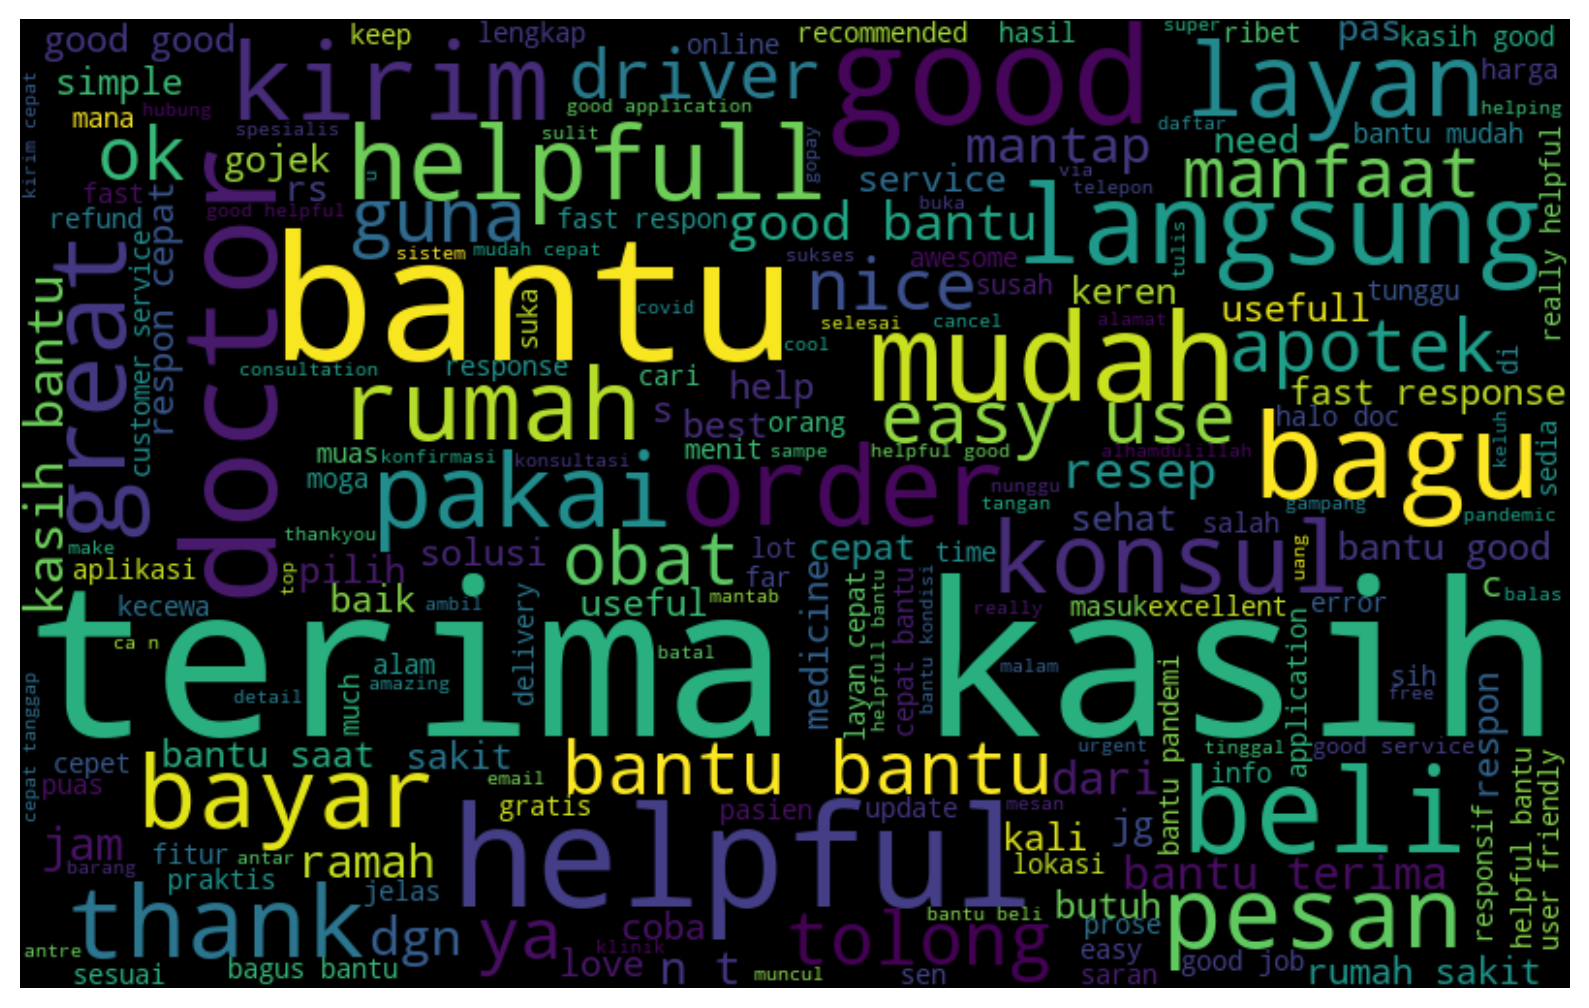

In [145]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools

# Assuming you have a DataFrame df with a 'Stemmer' column containing lists of words
flattened_words = list(itertools.chain.from_iterable(df_hdrev2['Stemmer']))
all_words = ' '.join(flattened_words)

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
stop_removal = df_hdrev2[['Stemmer']]

def fit_stopwords(text) :
  text = np.array(text)
  text = ' '.join(text)

# text = text.tostring()
# text = str(text)

  return text

df_hdrev2['Stemmer'] = df_hdrev2['Stemmer'].apply(lambda x: fit_stopwords (x))

In [149]:
df_hdrev2

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       n_words  \
0            4   
1            2   
2            5   
3            1   
4            1   
...        ...   
35926        5   
35927       20   
35928        2   
35929        4   
35930        8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah sendiri   

       count

In [151]:
def freq_words(x, terms=30):
    # Flatten the list of lists
    all_words = [word for sublist in x for word in sublist]
    
    # Hitung frekuensi kata
    fdist = FreqDist(all_words)
    
    # Kembalikan kata-kata yang paling sering muncul
    return fdist.most_common(terms)

# Gunakan fungsi untuk menganalisis frekuensi kata
count_stemmer = freq_words(df_hdrev2['Stemmer'])

In [165]:
df_hdrev2['stemmerCount'] = [len(review.split()) for review in df_hdrev2['Stemmer']]
df_hdrev2['wordCount'] = [len(review.split()) for review in df_hdrev2['content']]

In [174]:
#Select only the relevant column
df_hdrev2.loc[:,["content","wordCount","clean","count_clean","token","normalisasi","no_stopwords","Stemmer","stemmerCount"]]

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       wordCount  \
0              4   
1              2   
2              5   
3              1   
4              1   
...          ...   
35926          5   
35927         20   
35928          2   
35929          4   
35930          8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah 

# RESULT

In [168]:
def freq_words(df_column):
  all_words = ' '.join([text for text in df_column])
  all_words = all_words.split()
  fdist = FreqDist(all_words)
  return pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

In [170]:
def bar_freq_words(df, column, n = 30):
  d = df.nlargest(columns=column, n = n)
  plt.figure(figsize=(50,10))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

In [ ]:
## Frequency Words

In [169]:
from nltk.probability import FreqDist

df_stemw = freq_words(df_hdrev2['Stemmer']).sort_values(by=['count'], ascending=False)
df_stemw.head()

word  count
4     bantu   8166
3      good   4380
23    kasih   3171
22   terima   3080
12  helpful   2545

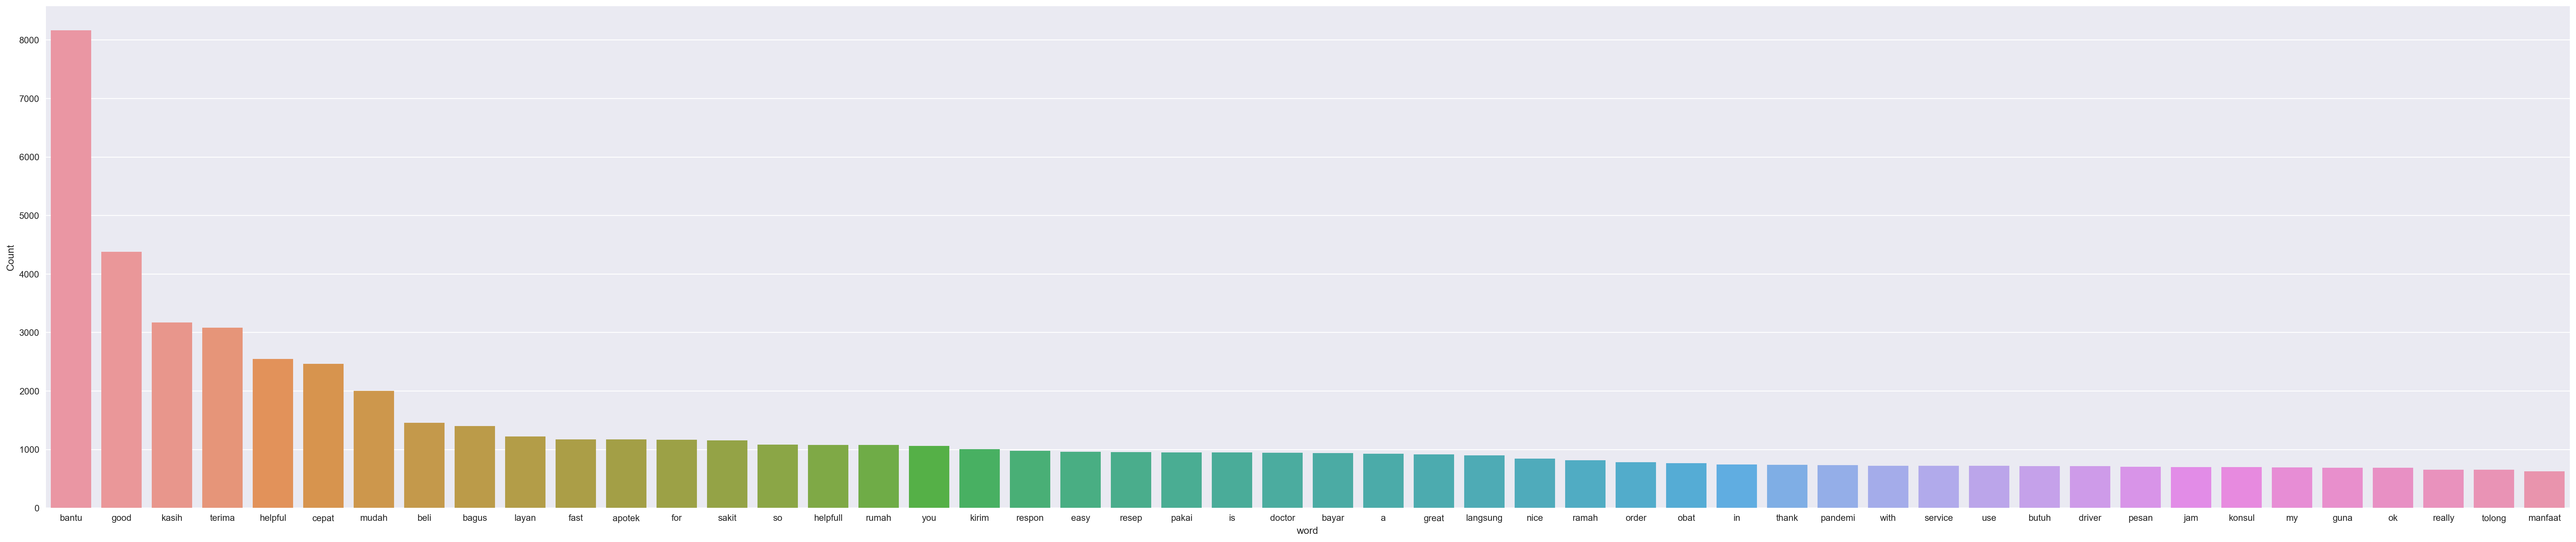

In [171]:
import seaborn as sns

bar_freq_words(df_stemw, 'count', 50)

In [172]:
#Print the after stemming before sentiment rating
df_hdrev2.to_csv(r'df_halodoc_after_stemming.csv', index=False)

## Rating Score

In [177]:
df_hdrev['score'].value_counts()

score
5    29710
1     2664
4     2201
3      755
2      601
Name: count, dtype: int64

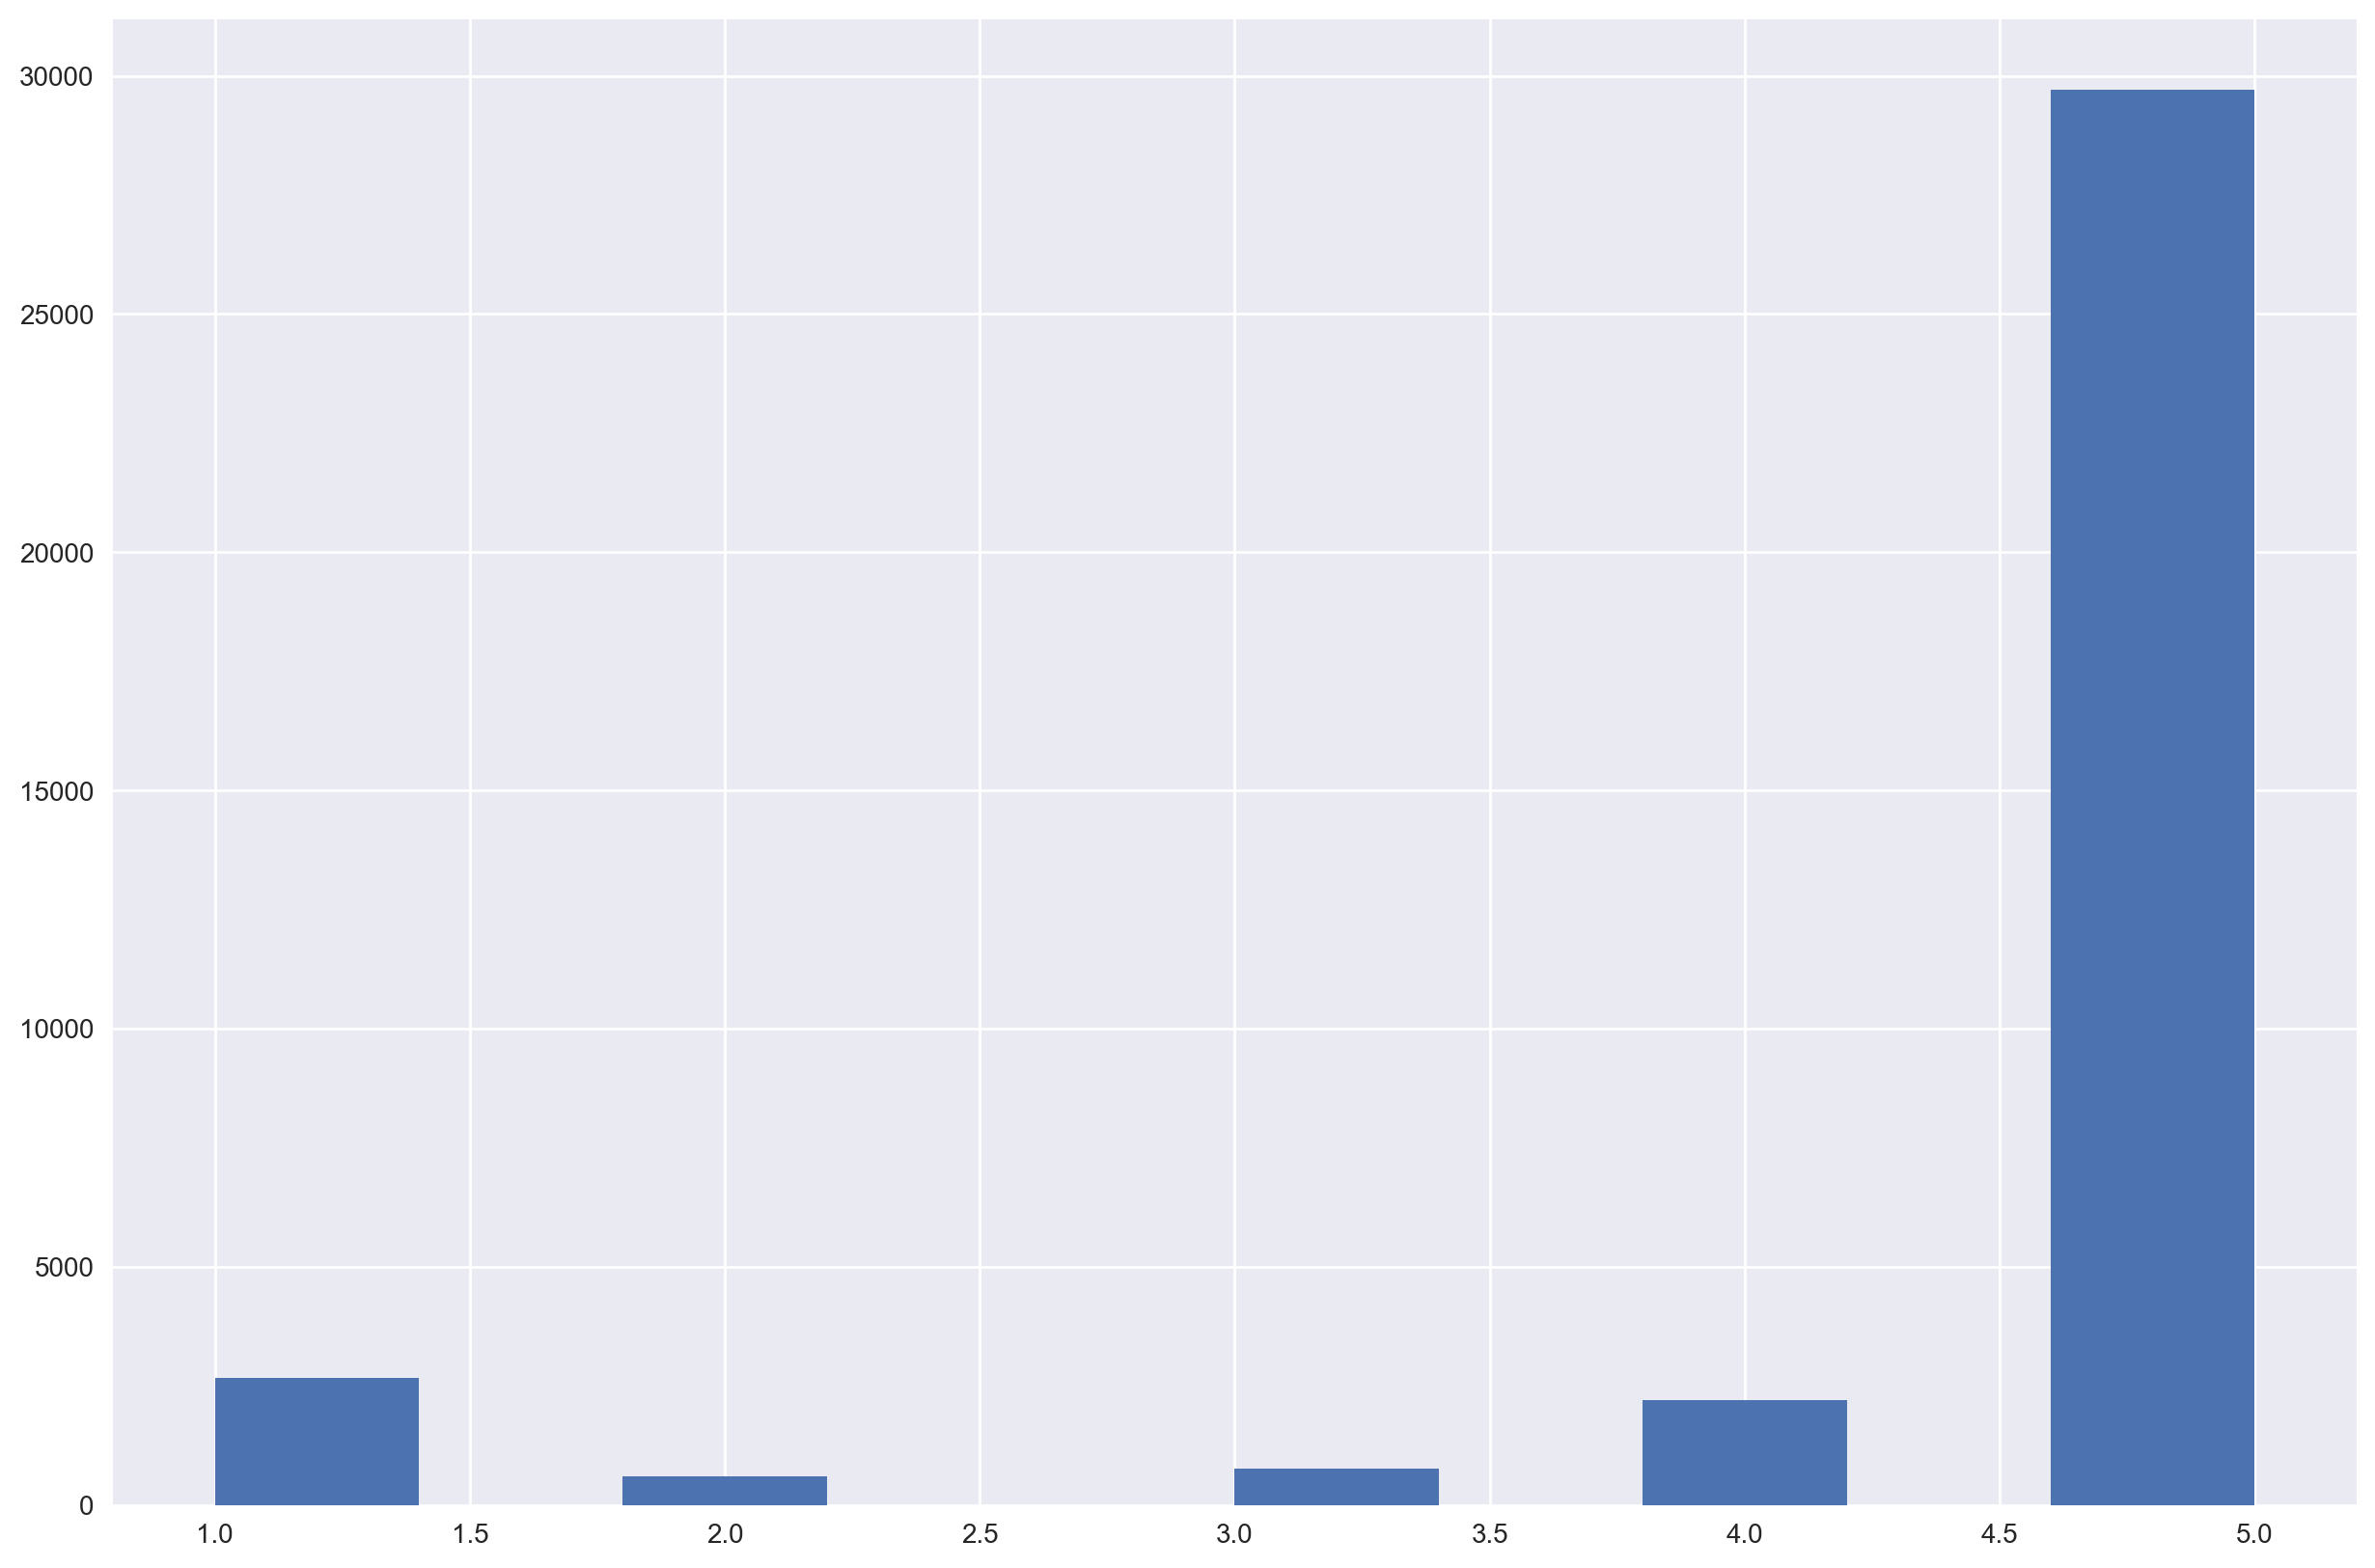

In [179]:
import matplotlib.pyplot as plt

plt.hist(df_hdrev['score'])
plt.show()

# Sentiment after Preprocessing

In [180]:
#menggunakan df_trev['no_stopwords']
from textblob import TextBlob
df_hdrev2['sentiment_polarity'] = df_hdrev2['Stemmer'].apply(lambda x: TextBlob(x).polarity)
df_hdrev2['sentiment_subjective'] = df_hdrev2['Stemmer'].apply(lambda x: TextBlob(x).subjectivity)

In [181]:
df_hdrev2['score'] = df_hdrev[['score']].copy()

In [182]:
df_hdrev2['sentiment_rating'] = df_hdrev2['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [183]:
#Select only the relevant column
df_hdrev2.loc[:,["content","wordCount","clean","count_clean","token","normalisasi","no_stopwords","Stemmer","stemmerCount", 'score', 'sentiment_polarity', 'sentiment_subjective', 'sentiment_rating']]

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       wordCount  \
0              4   
1              2   
2              5   
3              1   
4              1   
...          ...   
35926          5   
35927         20   
35928          2   
35929          4   
35930          8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35931 entries, 0 to 35930
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   content               35931 non-null  object 
 1   n_words               35931 non-null  int64  
 2   clean                 35931 non-null  object 
 3   count_clean           35931 non-null  int64  
 4   token                 35931 non-null  object 
 5   normalisasi           35931 non-null  object 
 6   Stopwords             35931 non-null  object 
 7   cleaned               35931 non-null  object 
 8   no_stopwords          35931 non-null  object 
 9   Stemmer               35931 non-null  object 
 10  stemmerCount          35931 non-null  int64  
 11  wordCount             35931 non-null  int64  
 12  sentiment_polarity    35931 non-null  float64
 13  sentiment_subjective  35931 non-null  float64
 14  score                 35931 non-null  int64  
 15  sentiment_rating   

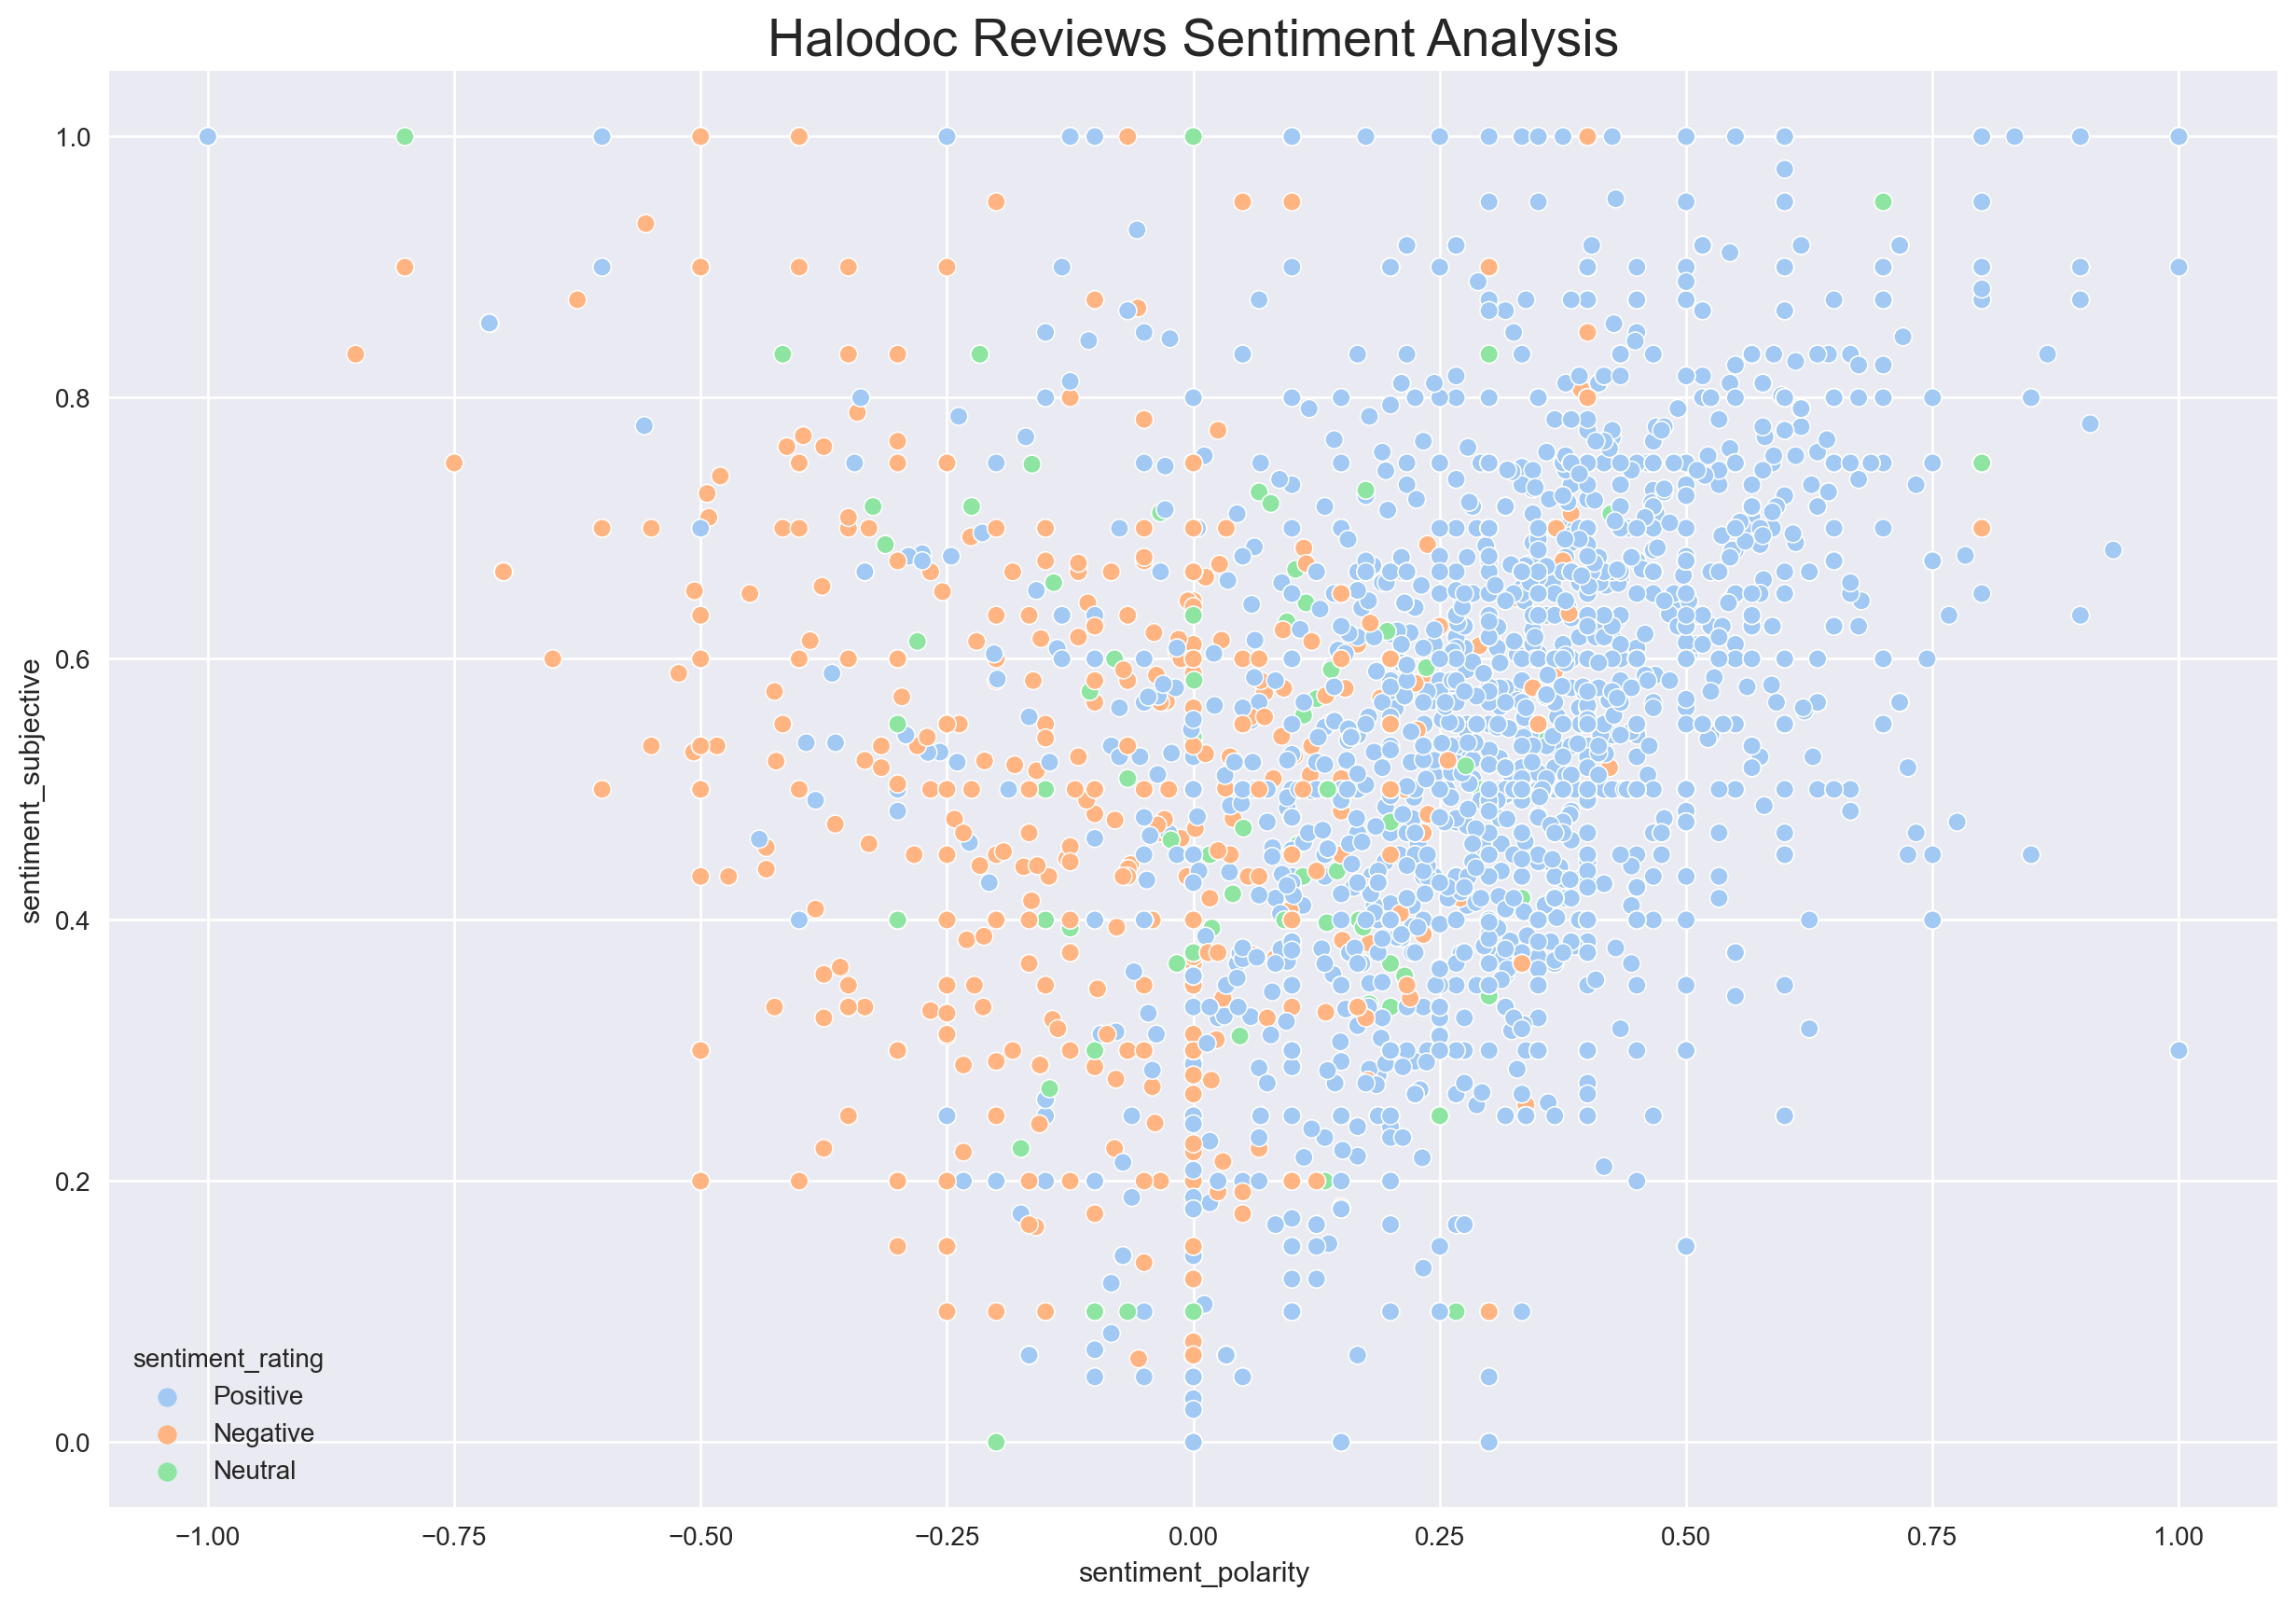

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

df_hdrev2.info()


sns.scatterplot(
    data=df_hdrev2,
    x='sentiment_polarity',
    y='sentiment_subjective',
    hue='sentiment_rating',
    edgecolor='white',
    palette="pastel"
)

plt.title("Halodoc Reviews Sentiment Analysis", fontsize=20)

plt.show()

In [187]:
#Print the after stemming before sentiment rating
df_hdrev2.to_csv(r'df_halodoc_after_sentiment_rating.csv', index=False)

# Separate the English Words Row, Select only Indo Rows 

In [190]:
!pip install langdetect

  Using cached langdetect-1.0.9.tar.gz (981 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993253 sha256=ff5a46d602e4e23bf3e8ee9da10cb0b3ed186dae570ce461fdbc5bb54bdc158f
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\0a\f2\b2\e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [195]:
import nltk
from nltk.corpus import words as english_words
from nltk.corpus import stopwords
import pandas as pd

# Download data yang diperlukan
nltk.download('words')
nltk.download('stopwords')

# Siapkan set kata-kata bahasa Inggris dan Indonesia
english_vocab = set(english_words.words())
indonesian_vocab = set(stopwords.words('indonesian'))

# Tambahkan beberapa kata umum bahasa Indonesia
indonesian_vocab.update(['saya', 'anda', 'dia', 'mereka', 'kami', 'kita', 'adalah', 'akan', 'sudah', 'belum', 'tidak', 'bukan', 'iya', 'ya'])

def detect_language(text):
    if isinstance(text, list):
        text = ' '.join(text)
    
    words = text.lower().split()
    
    en_count = sum(1 for word in words if word in english_vocab)
    id_count = sum(1 for word in words if word in indonesian_vocab)
    
    if en_count > id_count:
        return 'English'
    elif id_count > en_count:
        return 'Indonesian'
    else:
        return 'Indonesian'

# Terapkan fungsi ke kolom 'Stemmer'
df_hdrev2['language'] = df_hdrev2['Stemmer'].apply(detect_language)

# Tampilkan hasil
df_hdrev2[['Stemmer', 'language']]

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stemmer  \
0                                                               ramah   
1                                                                batu   
2                                                               butuh   
3                                                                good   
4                                                                good   
...                                                               ...   
35926                                                  s easy helpful   
35927  indonesia  hubung online  mudah informasi masalah sehat sumber   
35928                                                 good aplication   
35929                                             is simplying health   
35930                                              inovatif  rs rumah   

         language  
0      Indonesian  
1      Indonesian  
2      Indonesian  
3         English  
4         English  
...           ...  
35926     English  
35927  Indonesian  
35928     English  
35929     English  
35930  Indonesian  

[35931 rows x 2 columns]

In [196]:
#Select only the relevant column
df_hdrev2.loc[:,["content","wordCount","clean","count_clean","token","normalisasi","no_stopwords","Stemmer","stemmerCount", 'score', 'sentiment_polarity', 'sentiment_subjective', 'sentiment_rating','language']]

content  \
0                                                                                                                                        dokternya baik dan ramah.   
1                                                                                                                                                    cukup membatu   
2                                                                                                                                   sangat penting dan di butuhkan   
3                                                                                                                                                             good   
4                                                                                                                                                             good   
...                                                                                                                                                            ...   
35926                                                                                                                                   it's very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia.. yg menghubungkan online dg dokter.. memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat.   
35928                                                                                                                                              good aplication   
35929                                                                                                                                     this is simplying health   
35930                                                                                                   aplikasi inovatif... bisa mendatangkan rs ke rumah sendiri   

       wordCount  \
0              4   
1              2   
2              5   
3              1   
4              1   
...          ...   
35926          5   
35927         20   
35928          2   
35929          4   
35930          8   

                                                                                                                                                        clean  \
0                                                                                                                                    dokternya baik dan ramah   
1                                                                                                                                               cukup membatu   
2                                                                                                                              sangat penting dan di butuhkan   
3                                                                                                                                                        good   
4                                                                                                                                                        good   
...                                                                                                                                                       ...   
35926                                                                                                                               its very easy and helpful   
35927  sepertinya ini aplikasi pertama di indonesia yg menghubungkan online dg dokter memudahkan mendapat informasi permasalahan kesehatan dg sumber yg tepat   
35928                                                                                                                                         good aplication   
35929                                                                                                                                this is simplying health   
35930                                                                                                 aplikasi inovatif bisa mendatangkan rs ke rumah 

In [197]:
#Print the after stemming before sentiment rating
df_hdrev2.to_csv(r'df_halodoc_after_detectlang.csv', index=False)

In [7]:
# Analyze results 
print(df_hdrev2['sentiment_rating'].value_counts())

sentiment_rating
Positive    31911
Negative     3265
Neutral       755
Name: count, dtype: int64


In [8]:
# Analyze results 
print(df_hdrev2['language'].value_counts())

language
English       20113
Indonesian    15818
Name: count, dtype: int64
